# import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import sweetviz as sw

from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import lightgbm as lgb
import catboost as cat
import xgboost as xgb

# import category_encoders as ce
import optuna
import optuna.visualization as vis

# from imblearn.under_sampling import NearMiss

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

# get data

In [ ]:
raw_train = pd.read_csv('/content/drive/MyDrive/HackerEarth Challenge/churn_risk_rate_pred/data/train.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/HackerEarth Challenge/churn_risk_rate_pred/data/test.csv')

In [ ]:
print(raw_train.info())
raw_train.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
32261,fffe4300490044003700390033003600,Meghann Caudill,48,F,2HDPFBK,City,No Membership,2016-01-31,?,CID29206,Gift Vouchers/Coupons,Desktop,Mobile_Data,18:09:26,6,485.97,9257.56,6.0,619.32,Yes,No,No,Not Applicable,No reason specified,4


In [ ]:
train_len, test_len = raw_train.shape[0], raw_test.shape[0]

# eda

In [ ]:
eda = raw_train.copy()
edat = raw_test.copy()

## missing values

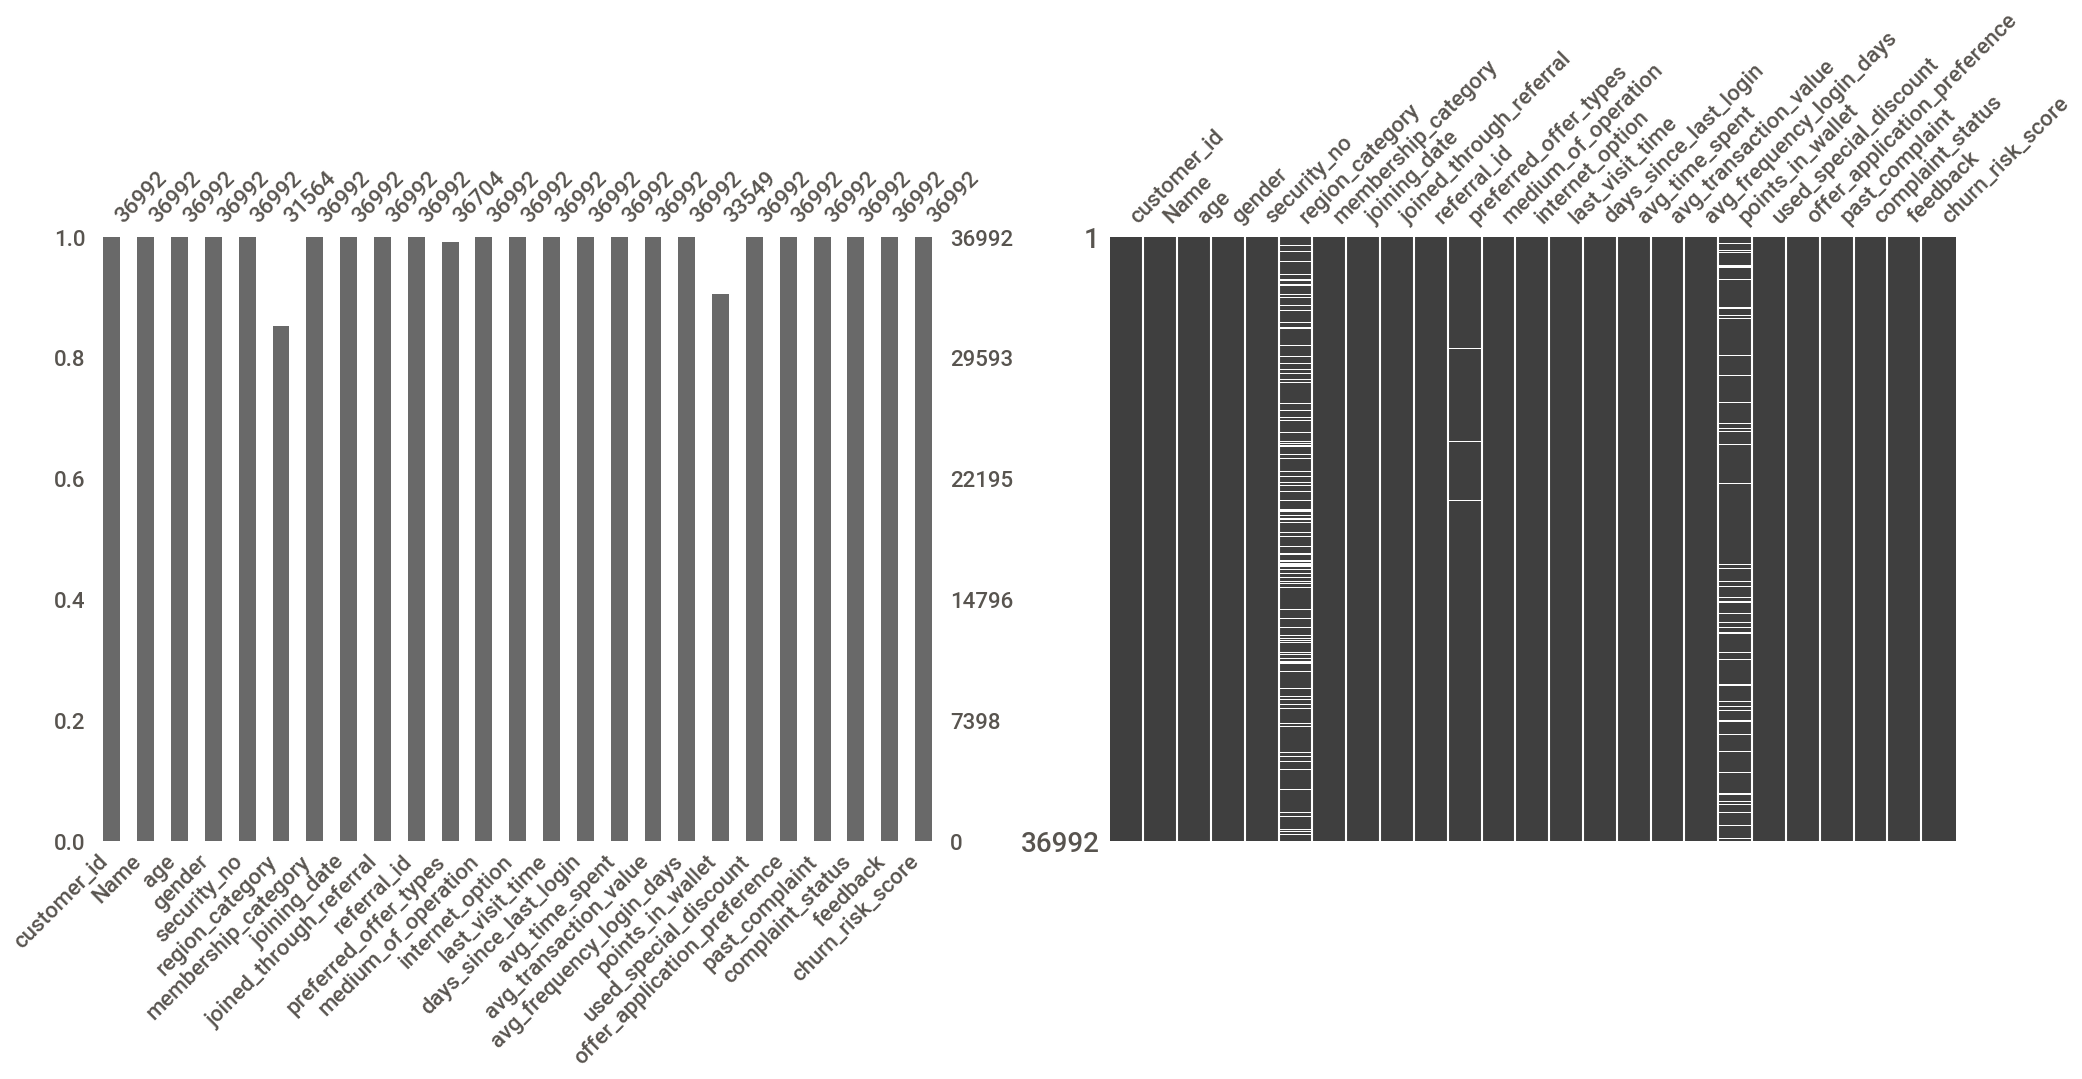

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(24, 8))
msno.bar(eda, ax=ax[0])
msno.matrix(eda, ax=ax[1])
plt.show()

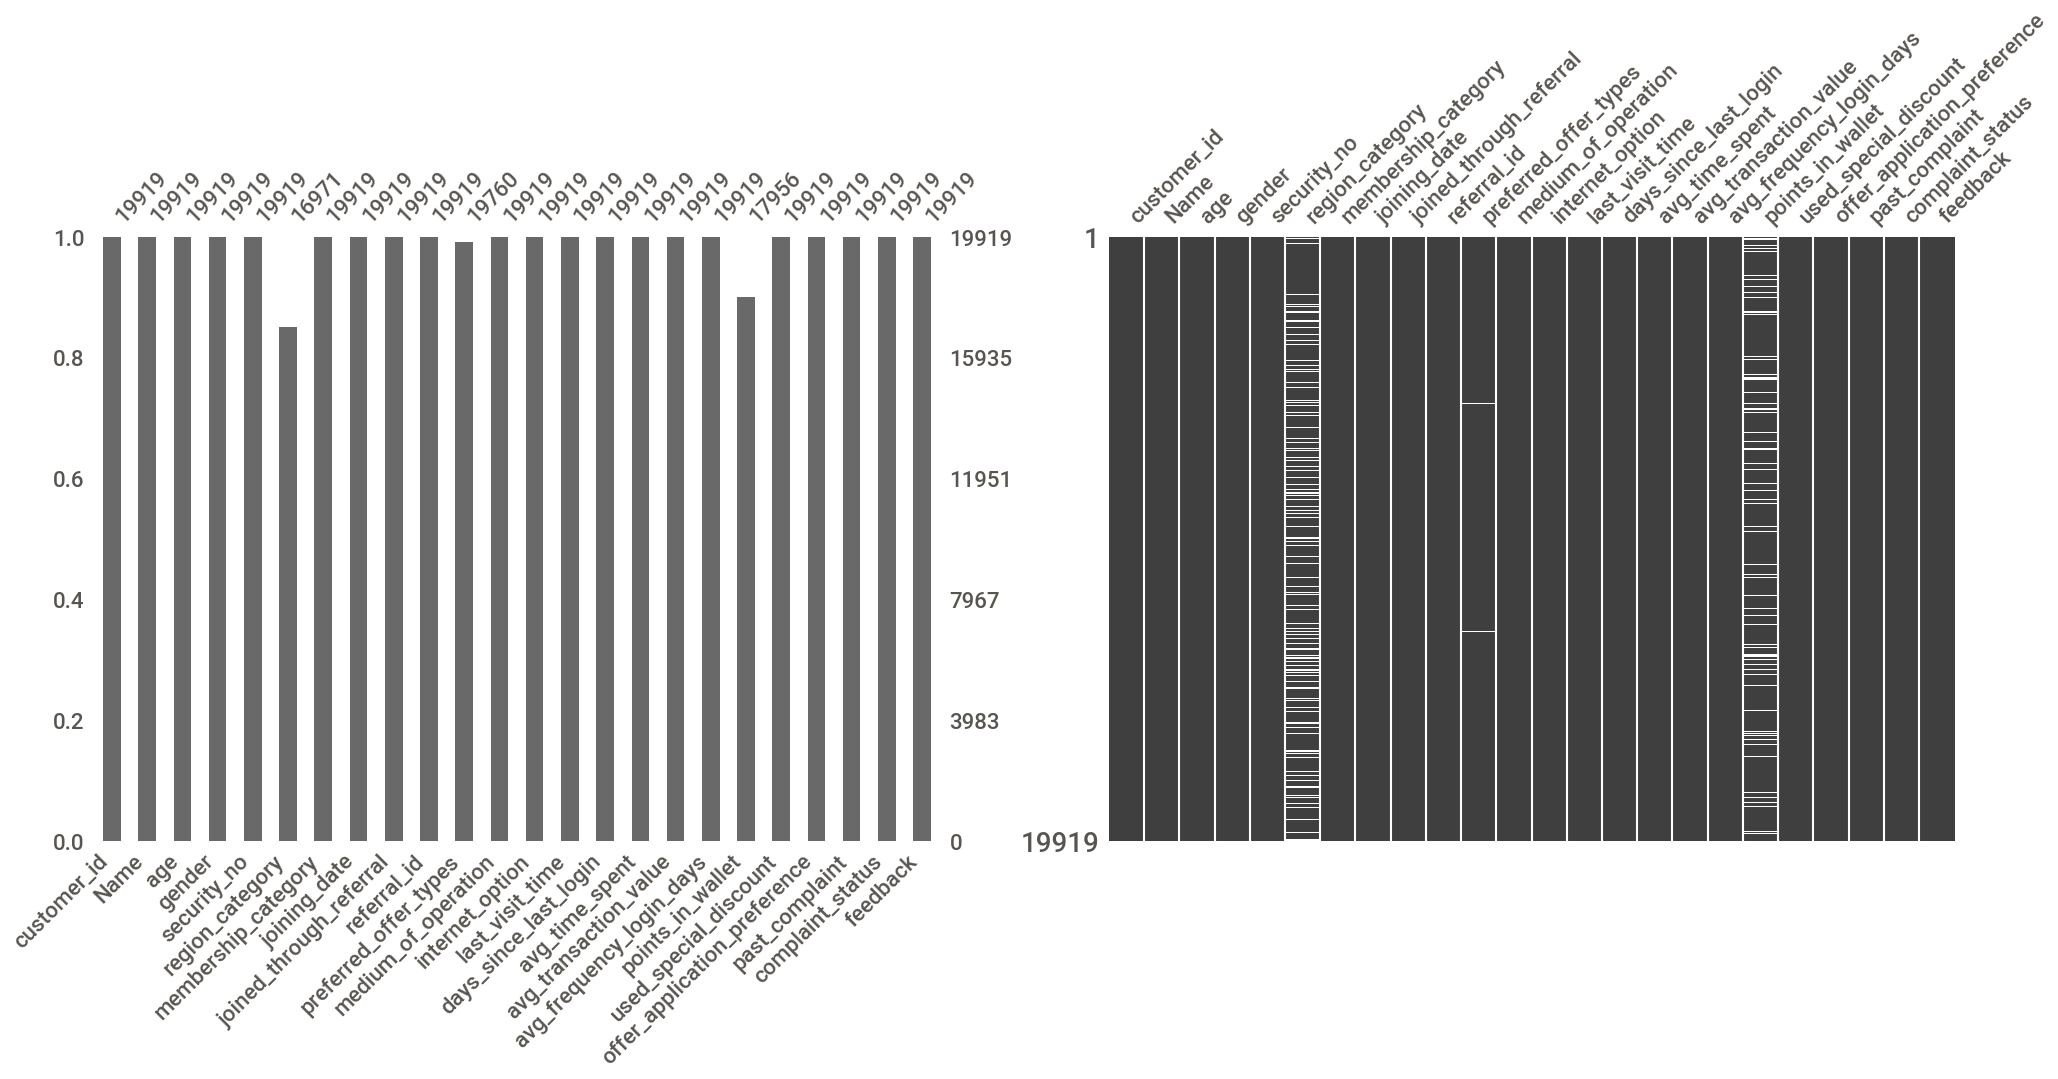

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(24, 8))
msno.bar(edat, ax=ax[0])
msno.matrix(edat, ax=ax[1])
plt.show()

## data cleaning

In [ ]:
eda['internet_option'].value_counts()

Wi-Fi          12413
Mobile_Data    12343
Fiber_Optic    12236
Name: internet_option, dtype: int64

In [ ]:
mask = eda['internet_option'] == 'Fiber_Optic'
eda.loc[mask, 'medium_of_operation'].value_counts()

Smartphone    4671
Desktop       4572
?             1741
Both          1252
Name: medium_of_operation, dtype: int64

In [ ]:
mask = eda['avg_frequency_login_days'] != 'Error'
eda.loc[mask, 'avg_frequency_login_days'].astype(float).astype(int).value_counts()

SyntaxError: ignored

In [ ]:
mask = eda['past_complaint'] == 'Yes'
eda.loc[mask, 'complaint_status'].value_counts()

Solved in Follow-up         2590
No Information Available    2550
Unsolved                    2452
Solved                      2377
Name: complaint_status, dtype: int64

In [ ]:
eda['joined_through_referral'].value_counts()

Yes    8617
No     8304
?      2998
Name: joined_through_referral, dtype: int64

In [ ]:
mask = eda['joined_through_referral'] == 'Yes'
eda.loc[mask, 'referral_id'].value_counts()

xxxxxxxx    840
CID31145      6
CID51723      5
CID45531      5
CID40328      5
           ... 
CID28868      1
CID46524      1
CID43138      1
CID38288      1
CID55735      1
Name: referral_id, Length: 6094, dtype: int64

In [ ]:
mask = eda['referral_id'] == 'xxxxxxxx'
eda.loc[mask, 'joined_through_referral'].value_counts()

No     8304
Yes     840
?       310
Name: joined_through_referral, dtype: int64

In [ ]:
mask = raw_train['churn_risk_score'] == -1
raw_train.loc[mask, 'feedback'].value_counts()

No reason specified         218
Poor Website                211
Poor Product Quality        198
Poor Customer Service       196
Too many ads                183
User Friendly Website        45
Quality Customer Care        40
Products always in Stock     37
Reasonable Price             35
Name: feedback, dtype: int64

# preprocess_2

In [ ]:
mask = raw_train['churn_risk_score'] != -1
train = raw_train.loc[mask]
test = raw_test.copy()

print(train.shape, test.shape)

(35829, 25) (19919, 24)


## drop cols

In [ ]:
ignore = ['Name', 'customer_id', 'security_no', 'last_visit_time', 'region_category']
train = raw_train.drop(ignore, axis=1)
test = raw_test.drop(ignore, axis=1)

In [ ]:
print(train.info())
train.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   membership_category           36992 non-null  object 
 3   joining_date                  36992 non-null  object 
 4   joined_through_referral       36992 non-null  object 
 5   referral_id                   36992 non-null  object 
 6   preferred_offer_types         36704 non-null  object 
 7   medium_of_operation           36992 non-null  object 
 8   internet_option               36992 non-null  object 
 9   days_since_last_login         36992 non-null  int64  
 10  avg_time_spent                36992 non-null  float64
 11  avg_transaction_value         36992 non-null  float64
 12  avg_frequency_login_days      36992 non-null  object 
 13  p

,age,gender,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
29695,27,M,Basic Membership,2017-12-03,No,xxxxxxxx,Without Offers,Both,Fiber_Optic,13,294.34,44822.03,27.0,280.318197,Yes,Yes,Yes,No Information Available,Poor Product Quality,5


## drop missing rows

In [ ]:
train.dropna(axis=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33288 entries, 0 to 36991
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           33288 non-null  int64  
 1   gender                        33288 non-null  object 
 2   membership_category           33288 non-null  object 
 3   joining_date                  33288 non-null  object 
 4   joined_through_referral       33288 non-null  object 
 5   referral_id                   33288 non-null  object 
 6   preferred_offer_types         33288 non-null  object 
 7   medium_of_operation           33288 non-null  object 
 8   internet_option               33288 non-null  object 
 9   days_since_last_login         33288 non-null  int64  
 10  avg_time_spent                33288 non-null  float64
 11  avg_transaction_value         33288 non-null  float64
 12  avg_frequency_login_days      33288 non-null  object 
 13  p

## gender

In [ ]:
train['gender'] = train['gender'].replace('Unknown', 'M')
test['gender'] = test['gender'].replace('Unknown', 'M')

# preprocess

In [ ]:
full_df = pd.concat([raw_train, raw_test]).reset_index(drop=True)
train_len, test_len = raw_train.shape[0], raw_test.shape[0]

## drop columns

In [ ]:
ignore = ['Name', 'customer_id', 'security_no', 'last_visit_time']
full_df = full_df.drop(ignore, axis=1)
print(f'Dataframe Shape: {full_df.shape}')
full_df.sample()

Dataframe Shape: (56911, 21)


,age,gender,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
18515,46,F,Village,Platinum Membership,2016-01-24,No,xxxxxxxx,Gift Vouchers/Coupons,Desktop,Mobile_Data,-999,321.84,13533.79,16.0,339.457571,No,Yes,No,Not Applicable,Quality Customer Care,1.0


## continuous features

In [ ]:
cont_df = full_df.select_dtypes(exclude='object')
cont_df.sample()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
38005,50,7,-1719.696995,28201.94,200.13646,NaN


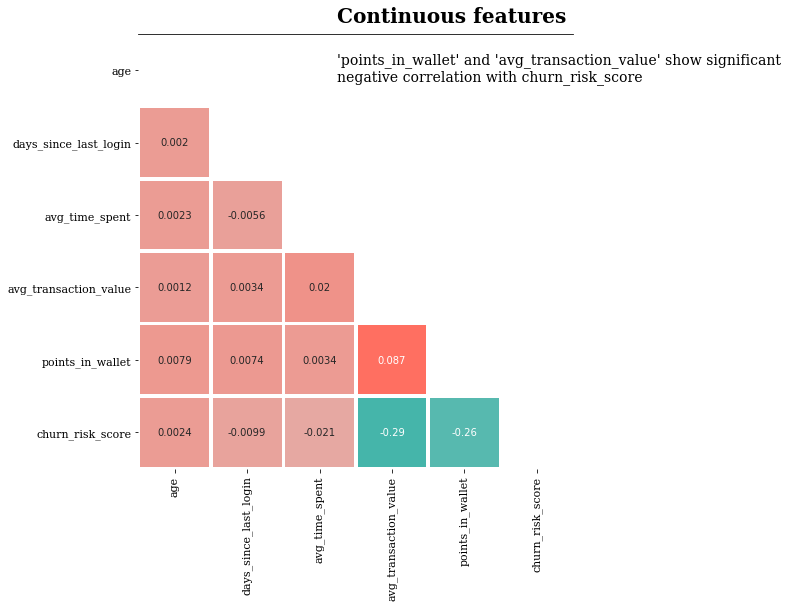

In [ ]:
import matplotlib

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

corr = cont_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

colors = ["#45b5aa","lightgray", "#ff6f61"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(
    corr, 
    square=True, 
    mask=mask,
    linewidth=2.5, 
    cmap=cmap, 
    cbar=False, 
    ax=ax,
    annot=True
)

ax.set_yticklabels(ax.get_xticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.spines['top'].set_visible(True)

fig.text(0.48, 0.9, s='Continuous features', fontweight='bold', fontfamily='serif', fontsize=20)
fig.text(0.48, 0.8, 
         s="'points_in_wallet' and 'avg_transaction_value' show significant \nnegative correlation with churn_risk_score", 
         fontfamily='serif', fontsize=14,
)

plt.show()

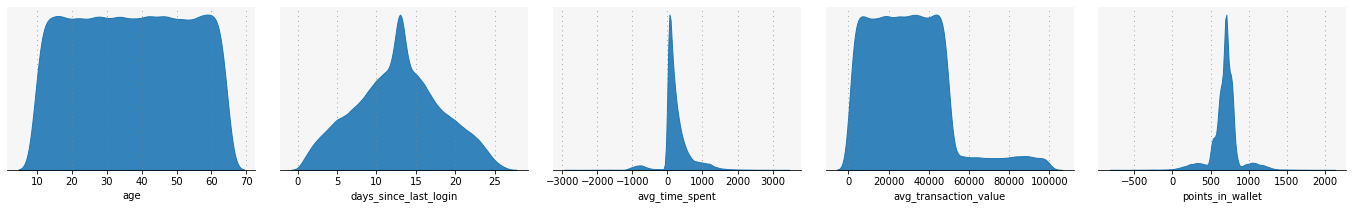

In [ ]:
fig = plt.figure(figsize=(24, 3))
gs = fig.add_gridspec(1,5)
gs.update(wspace=0.1, hspace=0.4)

background_color = "#f6f6f6"

run_no = 0
for row in range(1):
    for col in range(5):
        locals()[f'ax{run_no}'] = fig.add_subplot(gs[row, col])
        locals()[f'ax{run_no}'].set_facecolor(background_color)
        locals()[f'ax{run_no}'].tick_params(axis='y', left=False)
        locals()[f'ax{run_no}'].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()[f'ax{run_no}'].spines[s].set_visible(False)
        run_no += 1

for i, feat in enumerate(cont_df.columns[:-1]):
    sns.kdeplot(full_df[feat], ax=locals()[f'ax{i}'], shade=True, alpha=0.9)
    locals()[f'ax{i}'].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))


plt.show()

In [ ]:
cont_df.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,56911.000000,56911.000000,56911.000000,56911.000000,51505.000000,36992.000000
mean,37.036355,-40.970902,243.704243,29287.618994,686.563762,3.463397
std,15.885146,226.896073,400.262304,19466.710286,193.398290,1.409661
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,-1.000000
25%,23.000000,8.000000,59.830000,14195.630000,615.970000,3.000000
50%,37.000000,12.000000,161.620000,27560.380000,697.820000,4.000000
75%,51.000000,16.000000,355.460000,40896.595000,764.280000,5.000000
max,64.000000,26.000000,3350.060000,99995.030000,2069.069761,5.000000


In [ ]:
mask = (full_df['avg_transaction_value'] < 30000) & (full_df['churn_risk_score'] == 4)
full_df[mask].shape

(5947, 20)

In [ ]:
full_df['avg_time_spent'].value_counts()

34.710000      29
34.100000      27
33.280000      26
33.710000      25
30.560000      25
               ..
1765.728059     1
375.620000      1
65.960000       1
35.720000       1
85.720000       1
Name: avg_time_spent, Length: 35745, dtype: int64

In [ ]:
full_df['days_since_last_login'] = full_df['days_since_last_login'].replace({-999: np.nan})
full_df['days_since_last_login'] = full_df['days_since_last_login'].fillna(full_df['days_since_last_login'].median())

In [ ]:
full_df['points_in_wallet'] = full_df['points_in_wallet'].fillna(full_df['points_in_wallet'].median())

## categorical features

In [ ]:
full_df['gender'] = full_df['gender'].replace('Unknown', 'M')

In [ ]:
full_df['days_passed'] = (pd.to_datetime('2018-01-01') - pd.to_datetime(full_df['joining_date'])).dt.days
# full_df['join_month'] = pd.to_datetime(full_df['joining_date']).dt.month
# full_df['join_year'] = pd.to_datetime(full_df['joining_date']).dt.year
full_df = full_df.drop('joining_date', axis=1)

In [ ]:
feedback_map = {
    'Products always in Stock': 'Positive', 
    'Quality Customer Care': 'Positive',
    'Poor Website': 'Negative', 
    'No reason specified': 'Negative', 
    'Poor Product Quality': 'Negative',
    'Poor Customer Service': 'Negative', 
    'Too many ads': 'Negative', 
    'User Friendly Website': 'Positive',
    'Reasonable Price': 'Positive'
}

In [ ]:
full_df['feedback'] = full_df['feedback'].map(feedback_map)

In [ ]:
# mask = full_df['joined_through_referral'] == 'No'
mask = full_df['referral_id'] == 'xxxxxxxx'
full_df.loc[mask, 'joined_through_referral'] = 'No'
full_df['joined_through_referral'] = full_df['joined_through_referral'].replace('?', 'Yes')
full_df.drop('referral_id', axis=1, inplace=True)

In [ ]:
full_df['avg_frequency_login_days'] = full_df['avg_frequency_login_days'].replace('Error', np.nan).astype(np.float64)
full_df['avg_frequency_login_days'] = full_df['avg_frequency_login_days'].fillna(full_df['avg_frequency_login_days'].median()).abs()

In [ ]:
cat_df = full_df.copy()
print(cat_df.info())
cat_df.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56911 entries, 0 to 56910
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           56911 non-null  int64  
 1   gender                        56911 non-null  object 
 2   region_category               48535 non-null  object 
 3   membership_category           56911 non-null  object 
 4   joined_through_referral       56911 non-null  object 
 5   preferred_offer_types         56464 non-null  object 
 6   medium_of_operation           56911 non-null  object 
 7   internet_option               56911 non-null  object 
 8   days_since_last_login         56911 non-null  float64
 9   avg_time_spent                56911 non-null  float64
 10  avg_transaction_value         56911 non-null  float64
 11  avg_frequency_login_days      56911 non-null  float64
 12  points_in_wallet              56911 non-null  float64
 13  u

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,days_passed
40758,25,M,City,Silver Membership,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,9.0,145.55,13946.74,25.0,714.68,Yes,No,Yes,No Information Available,Negative,NaN,339


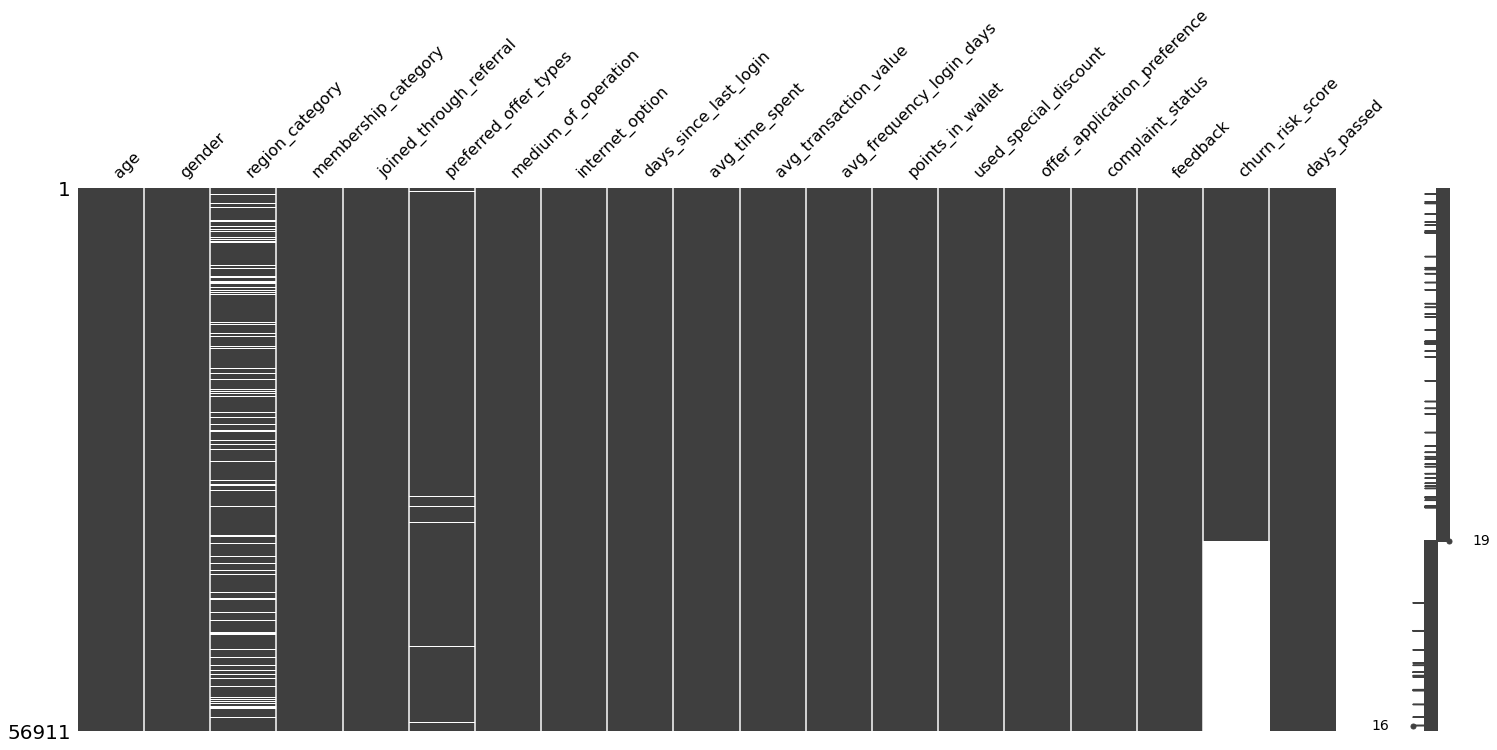

In [ ]:
msno.matrix(cat_df)

In [ ]:
mask = ~cat_df['region_category'].isna()
filt_cat_df = cat_df[mask]
filt_cat_df

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,complaint_status,feedback,churn_risk_score,days_passed
0,18,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,?,Wi-Fi,17.0,300.63,53005.25,17.0,781.750000,Yes,Yes,Not Applicable,Positive,2.0,137
1,32,F,City,Premium Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,16.0,306.34,12838.38,10.0,697.820000,Yes,No,Solved,Positive,1.0,126
2,44,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14.0,516.16,21027.00,22.0,500.690000,No,Yes,Solved in Follow-up,Negative,5.0,416
3,37,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11.0,53.27,25239.56,6.0,567.660000,No,Yes,Unsolved,Negative,5.0,429
4,31,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20.0,113.13,24483.66,16.0,663.060000,No,Yes,Solved,Negative,5.0,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56905,58,M,Village,Gold Membership,No,Credit/Debit Card Offers,Desktop,Wi-Fi,11.0,113.63,10004.18,10.0,622.460000,No,Yes,Not Applicable,Negative,NaN,911
56907,40,F,Village,No Membership,Yes,Without Offers,Desktop,Fiber_Optic,21.0,63.19,23466.26,16.0,574.340000,No,Yes,Not Applicable,Negative,NaN,1
56908,55,M,Town,No Membership,No,Credit/Debit Card Offers,Desktop,Mobile_Data,18.0,68.72,17903.75,24.0,564.300000,No,Yes,Unsolved,Negative,NaN,845
56909,17,F,City,Silver Membership,Yes,Credit/Debit Card Offers,Smartphone,Fiber_Optic,3.0,119.54,14057.09,22.0,606.340000,No,Yes,Not Applicable,Negative,NaN,624


In [ ]:
X = filt_cat_df.drop(['region_category', 'churn_risk_score', 'preferred_offer_types'], axis=1)
y = filt_cat_df['region_category']

print(X.shape, y.shape)

(48535, 16) (48535,)


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48535 entries, 0 to 56910
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           48535 non-null  int64  
 1   gender                        48535 non-null  object 
 2   membership_category           48535 non-null  object 
 3   joined_through_referral       48535 non-null  object 
 4   medium_of_operation           48535 non-null  object 
 5   internet_option               48535 non-null  object 
 6   days_since_last_login         48535 non-null  float64
 7   avg_time_spent                48535 non-null  float64
 8   avg_transaction_value         48535 non-null  float64
 9   avg_frequency_login_days      48535 non-null  float64
 10  points_in_wallet              48535 non-null  float64
 11  used_special_discount         48535 non-null  object 
 12  offer_application_preference  48535 non-null  object 
 13  c

In [ ]:
ord_feats = [feat for feat in X.columns if X[feat].nunique() == 2]
oh_feats = [feat for feat in X.columns if X[feat].nunique() > 2 and X[feat].dtype == 'object']
num_feats = X.select_dtypes(exclude='object').columns.tolist()

print(ord_feats)
print(oh_feats)
print(num_feats)

['gender', 'joined_through_referral', 'used_special_discount', 'offer_application_preference', 'feedback']
['membership_category', 'medium_of_operation', 'internet_option', 'complaint_status']
['age', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet', 'days_passed']


In [ ]:
pipeline = ColumnTransformer([
        ('scaler', StandardScaler(), num_feats),
        ('label_enc', ce.ordinal.OrdinalEncoder(), ord_feats),
        ('oh_enc', ce.one_hot.OneHotEncoder(), oh_feats)
])

In [ ]:
clean_X = pipeline.fit_transform(X)
clean_X.shape

(48535, 30)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
le = LabelEncoder()
clean_y = le.fit_transform(y)
clean_y

array([2, 0, 1, ..., 1, 0, 1])

In [ ]:
from umap.umap_ import UMAP

In [ ]:
reducer = UMAP()

In [ ]:
flat_data = reducer.fit_transform(clean_X, clean_y)

Text(0.5, 1.0, 'UMAP projection of the given dataset')

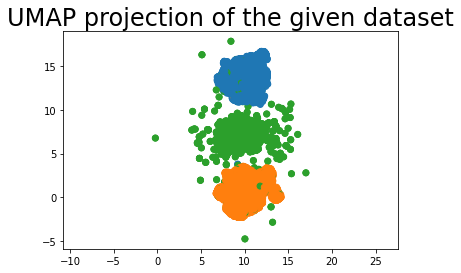

In [ ]:
plt.scatter(
    flat_data[:, 0],
    flat_data[:, 1],
    c=[sns.color_palette()[x] for x in clean_y])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the given dataset', fontsize=24)

In [ ]:
rf = RandomForestClassifier()

In [ ]:
cross_val_score(rf, flat_data, clean_y)

array([0.99206758, 0.99114041, 0.99165551, 0.99258267, 0.99093438])

In [ ]:
rf.fit(flat_data, clean_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
mask = cat_df['region_category'].isna()
test_region = cat_df[mask].drop(['region_category', 'churn_risk_score', 'preferred_offer_types'], axis=1)
test_region

,age,gender,membership_category,joined_through_referral,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,complaint_status,feedback,days_passed
7,42,M,No Membership,Yes,Both,Fiber_Optic,19.0,429.110000,44554.82,24.0,568.080000,No,Yes,Unsolved,Negative,538
32,11,F,Gold Membership,Yes,Desktop,Wi-Fi,10.0,185.530000,60143.68,4.0,836.080000,Yes,No,Solved in Follow-up,Positive,522
37,26,M,No Membership,Yes,Desktop,Wi-Fi,3.0,215.890000,41979.65,9.0,697.820000,No,Yes,Not Applicable,Negative,33
61,44,F,No Membership,Yes,Both,Wi-Fi,13.0,283.490000,7603.71,16.0,553.450000,Yes,Yes,Unsolved,Negative,496
64,10,M,Basic Membership,No,Smartphone,Fiber_Optic,12.0,31.670000,25436.23,16.0,656.670000,No,Yes,Not Applicable,Negative,938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56886,62,M,Silver Membership,No,Desktop,Wi-Fi,2.0,170.720000,97931.35,2.0,774.270000,No,Yes,Not Applicable,Positive,245
56887,50,F,Basic Membership,No,?,Wi-Fi,21.0,43.030000,4983.03,14.0,1032.334309,Yes,No,Solved,Negative,65
56894,42,F,Silver Membership,Yes,?,Fiber_Optic,14.0,-565.774744,3514.63,16.0,763.090000,Yes,No,Unsolved,Negative,391
56899,20,F,Gold Membership,No,Desktop,Fiber_Optic,20.0,227.340000,29378.71,9.0,697.820000,Yes,Yes,Unsolved,Negative,495


In [ ]:
clean_test = pipeline.transform(test_region)
clean_test.shape

(8376, 30)

In [ ]:
flat_test = reducer.transform(clean_test)
flat_test.shape

(8376, 2)

In [ ]:
from collections import Counter

In [ ]:
preds = rf.predict(flat_test)
preds

array([2, 2, 1, ..., 2, 1, 0])

In [ ]:
Counter(preds)

Counter({0: 220, 1: 3025, 2: 5131})

In [ ]:
missing_region = le.inverse_transform(preds)
print(missing_region)
missing_region.shape

['Village' 'Village' 'Town' ... 'Village' 'Town' 'City']


(8376,)

In [ ]:
mask = full_df['region_category'].isna()
full_df.loc[mask, 'region_category'] = missing_region

In [ ]:
full_df['preferred_offer_types'].value_counts()

Credit/Debit Card Offers    18876
Gift Vouchers/Coupons       18844
Without Offers              18744
Name: preferred_offer_types, dtype: int64

In [ ]:
full_df['preferred_offer_types'] = full_df['preferred_offer_types'].fillna('Without Offers')

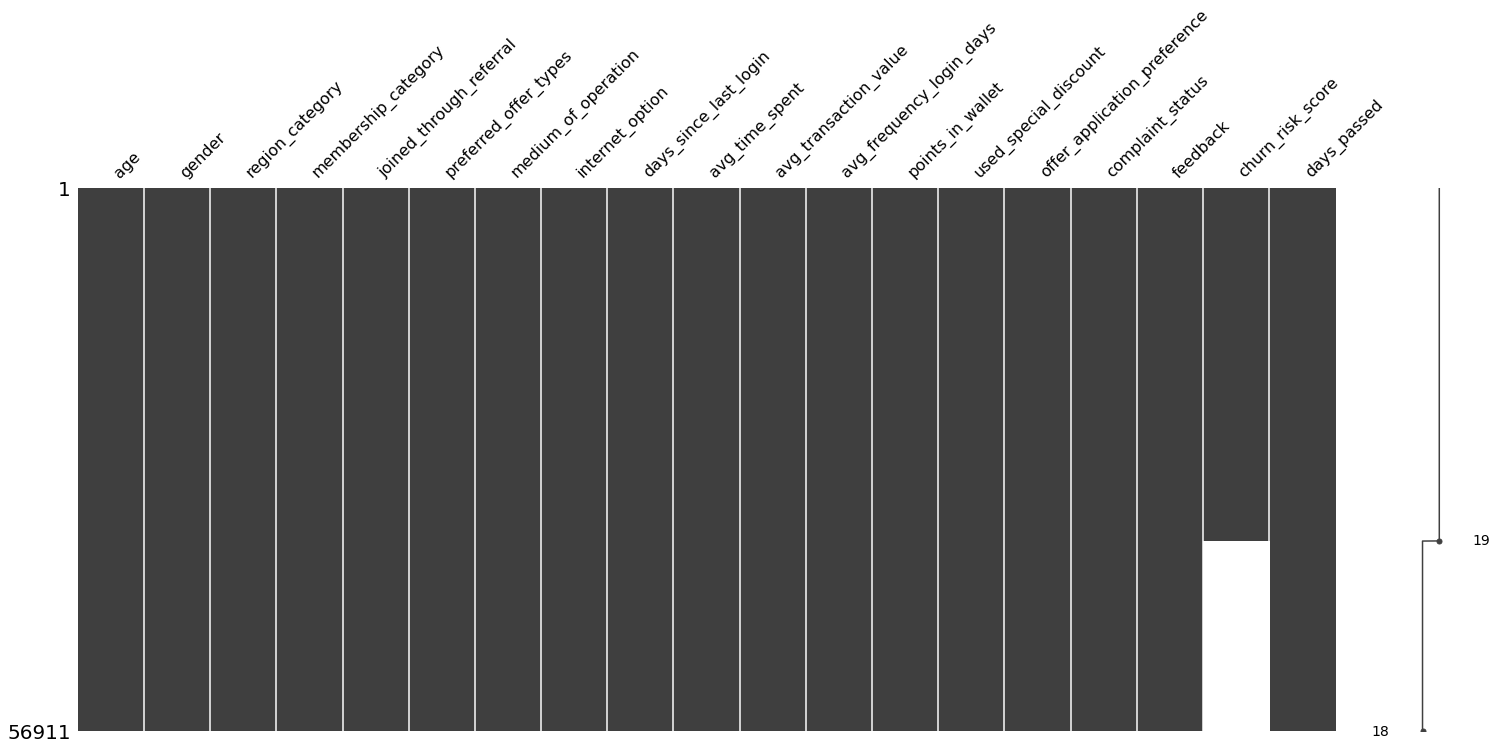

In [ ]:
msno.matrix(full_df)

In [ ]:
full_df.to_csv('transformed_data.csv', index=False)

In [ ]:
full_df.groupby(['preferred_offer_types', 'medium_of_operation']).count()['age']

preferred_offer_types     medium_of_operation
Credit/Debit Card Offers  ?                      2753
                          Both                   1931
                          Desktop                7069
                          Smartphone             7123
Gift Vouchers/Coupons     ?                      2734
                          Both                   1971
                          Desktop                7158
                          Smartphone             6981
Without Offers            ?                      2800
                          Both                   1954
                          Desktop                6977
                          Smartphone             7013
Name: age, dtype: int64

In [ ]:
# full_df = full_df.drop('region_category', axis=1)

In [ ]:
cat_df = full_df.select_dtypes(exclude='float')
cat_df.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,avg_frequency_login_days,used_special_discount,offer_application_preference,complaint_status,feedback,days_passed
0,18,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,?,Wi-Fi,17.0,Yes,Yes,Not Applicable,Positive,137
1,32,F,City,Premium Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,10.0,Yes,No,Solved,Positive,126
2,44,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,22.0,No,Yes,Solved in Follow-up,Negative,416
3,37,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,6.0,No,Yes,Unsolved,Negative,429
4,31,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,16.0,No,Yes,Solved,Negative,111


In [ ]:
oe = ce.ordinal.OrdinalEncoder()
cat_df = oe.fit_transform(cat_df)
cat_df.isna().sum()

gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
avg_frequency_login_days        0
used_special_discount           0
offer_application_preference    0
complaint_status                0
feedback                        0
dtype: int64

In [ ]:
cat_df['region_category'] = cat_df['region_category'].replace(4, np.nan)
cat_df['preferred_offer_types'] = cat_df['preferred_offer_types'].replace(4, np.nan)

In [ ]:
cat_df['region_category'].apply(round).value_counts(dropna=False)

2    27905
3    21763
1     7243
Name: region_category, dtype: int64

In [ ]:
imputer = IterativeImputer(max_iter=20)

In [ ]:
3.000000    21763
2.000000    19529
1.000000     7243

2

In [ ]:
cat_df_fill = pd.DataFrame(imputer.fit_transform(cat_df), columns=cat_df.columns)
cat_df_fill.head()

,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,avg_frequency_login_days,used_special_discount,offer_application_preference,complaint_status,feedback
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
2,1.0,3.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,1.0,3.0,2.0
3,2.0,2.0,3.0,2.0,1.0,2.0,2.0,4.0,2.0,1.0,4.0,2.0
4,1.0,2.0,3.0,1.0,2.0,3.0,2.0,5.0,2.0,1.0,2.0,2.0


In [ ]:
cat_df_fill['preferred_offer_types'].apply(round).value_counts(dropna=False)

2    19323
1    18844
3    18744
Name: preferred_offer_types, dtype: int64

In [ ]:
round(1.829)

2

In [ ]:
cat_df = oe.inverse_transform(cat_df_fill)

In [ ]:
cat_df['preferred_offer_types'].value_counts()

Credit/Debit Card Offers    18876
Gift Vouchers/Coupons       18844
Without Offers              18744
Name: preferred_offer_types, dtype: int64

In [ ]:
# mask = full_df['referral_id'] == 'xxxxxxxx'
mask = full_df['joined_through_referral'] == 'No'
full_df.loc[mask, 'referral_id'].value_counts()

xxxxxxxx    27300
Name: referral_id, dtype: int64

In [ ]:
mask = full_df['feedback'] == 'Products always in Stock'
full_df.loc[mask, 'churn_risk_score'].value_counts()

 1.0    678
 2.0    667
-1.0     37
Name: churn_risk_score, dtype: int64

In [ ]:
def preprocess(dataframe, for_pycaret=False):
    df = dataframe.copy()
    
    if not for_pycaret:
        ignore_cols = ['customer_id', 'Name', 'security_no', 'referral_id', 'last_visit_time']
        df = df.drop(ignore_cols, axis=1)

    df['gender'] = df['gender'].replace('Unknown', np.nan)

    df['days_since_last_login'] = df['days_since_last_login'].replace(-999, 0)

    df['avg_time_spent'] = df['avg_time_spent'].abs()

    # df['avg_transaction_value'] = df['avg_transaction_value'].apply(lambda x: 'Nice' if x < 50000 else 'Not Nice')

    # df['avg_frequency_login_days'] = df['avg_frequency_login_days'].replace('Error', np.nan).astype(np.float64)
    df['avg_frequency_login_days'] = df['avg_frequency_login_days'].replace('Error', np.nan).astype(np.float64)
    df['avg_frequency_login_days'] = df['avg_frequency_login_days'].fillna(df['avg_frequency_login_days'].median()).abs()

    df['feedback'] = df['feedback'].map(feedback_map)

    if 'churn_risk_score' in df.columns:
        df['churn_risk_score'] = df['churn_risk_score'].replace(-1, 1) 

    return df

In [ ]:
train = preprocess(raw_train, for_pycaret=True)

In [ ]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36933 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Positive,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Positive,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Negative,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,11,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Negative,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,20,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Negative,5


In [ ]:
full_df.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,complaint_status,feedback,churn_risk_score,days_passed
0,18,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,?,Wi-Fi,17.0,300.63,53005.25,17.0,781.75,Yes,Yes,Not Applicable,Positive,2.0,137
1,32,F,City,Premium Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,16.0,306.34,12838.38,10.0,697.82,Yes,No,Solved,Positive,1.0,126
2,44,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14.0,516.16,21027.00,22.0,500.69,No,Yes,Solved in Follow-up,Negative,5.0,416
3,37,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11.0,53.27,25239.56,6.0,567.66,No,Yes,Unsolved,Negative,5.0,429
4,31,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20.0,113.13,24483.66,16.0,663.06,No,Yes,Solved,Negative,5.0,111


#sklearn

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56911 entries, 0 to 56910
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           56911 non-null  int64  
 1   gender                        56911 non-null  object 
 2   region_category               56911 non-null  object 
 3   membership_category           56911 non-null  object 
 4   joined_through_referral       56911 non-null  object 
 5   preferred_offer_types         56911 non-null  object 
 6   medium_of_operation           56911 non-null  object 
 7   internet_option               56911 non-null  object 
 8   days_since_last_login         56911 non-null  float64
 9   avg_time_spent                56911 non-null  float64
 10  avg_transaction_value         56911 non-null  float64
 11  avg_frequency_login_days      56911 non-null  float64
 12  points_in_wallet              56911 non-null  float64
 13  u

In [ ]:
cat_features = full_df.select_dtypes(include='object').columns.tolist()

In [ ]:
full_df[cat_features] = full_df[cat_features].astype('category')

In [ ]:
full_df['gender'].dtype

CategoricalDtype(categories=['F', 'M'], ordered=False)

In [ ]:
ord_feats = [feat for feat in full_df.columns if full_df[feat].nunique() == 2]
oh_feats = [feat for feat in full_df.columns if full_df[feat].nunique() > 2 and full_df[feat].dtype not in ['int', 'float']]
num_feats = full_df.select_dtypes(include=['int', 'float']).columns.tolist()
num_feats.remove('churn_risk_score')

print(ord_feats)
print(oh_feats)
print(num_feats)

['gender', 'joined_through_referral', 'used_special_discount', 'offer_application_preference', 'feedback']
['region_category', 'membership_category', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'complaint_status']
['age', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet', 'days_passed']


In [ ]:
['gender', 'joined_through_referral', 'used_special_discount', 'offer_application_preference', 'feedback']
['membership_category', 'medium_of_operation', 'internet_option', 'complaint_status']
['age', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet', 'days_passed']

In [ ]:
preprocess = ColumnTransformer([
        ('scaler', StandardScaler(), num_feats),
        ('label_enc', ce.ordinal.OrdinalEncoder(), ord_feats),
        ('oh_enc', ce.one_hot.OneHotEncoder(), oh_feats)
])

le = LabelEncoder()

In [ ]:
clean_train, clean_test = full_df.iloc[:train_len], full_df.iloc[train_len:]
print(clean_train.shape, clean_test.shape)

(36992, 19) (19919, 19)


In [ ]:
clean_train.to_csv('clean_train.csv', index=False)

NameError: ignored

In [ ]:
mask = clean_train['churn_risk_score'] != -1

In [ ]:
clean_train_X = clean_train.drop('churn_risk_score', axis=1).loc[mask]
clean_train_y = clean_train.loc[mask, 'churn_risk_score']

print(clean_train_X.shape, clean_train_y.shape)

(35829, 18) (35829,)


In [ ]:
final_X = preprocess.fit_transform(clean_train_X, clean_train_y)
final_X.shape

(35829, 36)

In [ ]:
final_y = le.fit_transform(clean_train_y)
final_y.shape

(35829,)

In [ ]:
from umap.umap_ import UMAP

In [ ]:
data_reducer = UMAP(random_state=1234)

In [ ]:
final_flat_data = data_reducer.fit_transform(final_X, final_y)

In [ ]:
final_flat_data.shape

(35829, 2)

In [ ]:
umap_train = pd.DataFrame({
    'col1': final_flat_data[:, 0],
    'col2': final_flat_data[:, 1],
    'label': clean_train_y.astype(int),  
})
umap_train.head()

,col1,col2,label
0,10.241261,13.758226,2
1,13.340265,7.341975,1
2,-2.845256,12.736478,5
3,-3.383483,13.804183,5
4,-3.390225,13.727459,5


In [ ]:
umap_train.to_csv('umap_train.csv', index=False)

In [ ]:
colors = ['red', 'green', 'blue', 'yellow', 'brown']

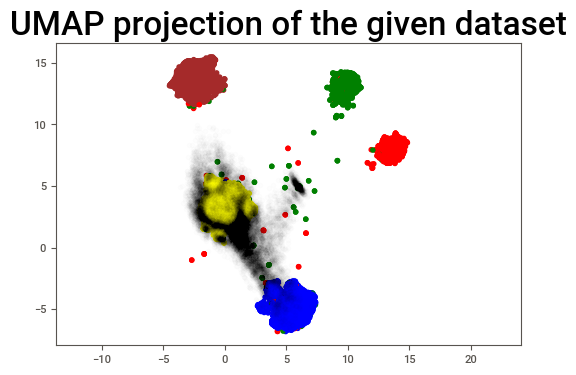

In [ ]:
plt.scatter(
    final_flat_data[:, 0],
    final_flat_data[:, 1],
    c=[colors[x] for x in final_y]
)
plt.scatter(
    final_test_flat[:, 0],
    final_test_flat[:, 1],
    c='black',  
    alpha=0.009,
    marker='o'
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the given dataset', fontsize=24)
plt.show()

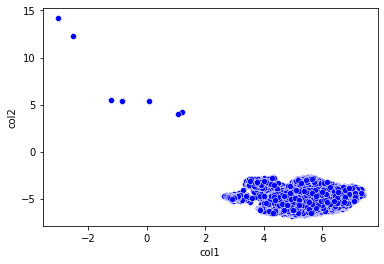

In [ ]:
target = 3
mask = umap_train['label'] == target
sns.scatterplot(data=umap_train.loc[mask], x='col1', y='col2', color=colors[target])

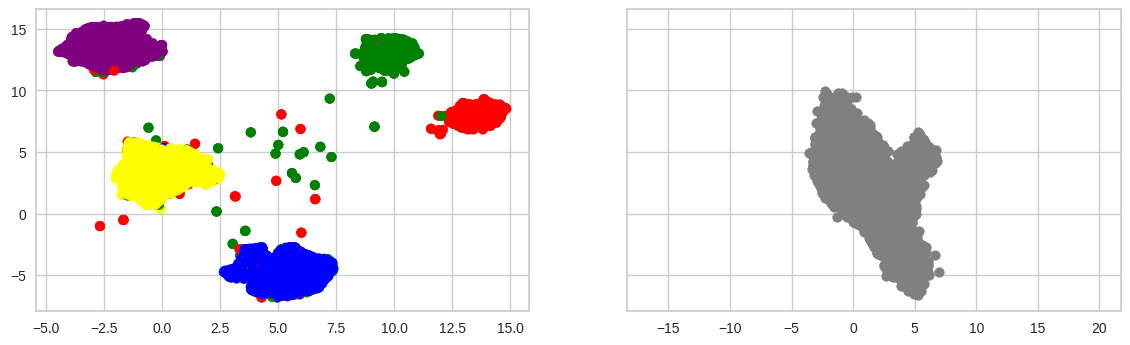

In [ ]:
colors = ['red', 'green', 'blue', 'yellow', 'purple']

fig, ax = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

ax[0].scatter(
    final_flat_data[:, 0],
    final_flat_data[:, 1],
    c=[colors[x] for x in final_y]
)

ax[1].scatter(
    final_test_flat[:, 0],
    final_test_flat[:, 1],
    c='grey',
)

plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the given dataset', fontsize=24)
plt.show()

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
cross_val_score(rfc, final_flat_data, final_y)

array([0.99399944, 0.99413899, 0.99511582, 0.99483673, 0.99413817])

In [ ]:
rfc.fit(final_flat_data, final_y)

RandomForestClassifier()

In [ ]:
clean_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19919 entries, 36992 to 56910
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   age                           19919 non-null  int64   
 1   gender                        19919 non-null  category
 2   region_category               19919 non-null  category
 3   membership_category           19919 non-null  category
 4   joined_through_referral       19919 non-null  category
 5   preferred_offer_types         19919 non-null  category
 6   medium_of_operation           19919 non-null  category
 7   internet_option               19919 non-null  category
 8   days_since_last_login         19919 non-null  float64 
 9   avg_time_spent                19919 non-null  float64 
 10  avg_transaction_value         19919 non-null  float64 
 11  avg_frequency_login_days      19919 non-null  float64 
 12  points_in_wallet              19919 non-nu

In [ ]:
clean_test_X = clean_test.drop('churn_risk_score', axis=1)

In [ ]:
final_test_X = preprocess.transform(clean_test_X)
final_test_X.shape

(19919, 36)

In [ ]:
final_test_flat = data_reducer.transform(final_test_X)
final_test_flat.shape

(19919, 2)

In [ ]:
umap_test = pd.DataFrame({
    'col1': final_test_flat[:, 0],
    'col2': final_test_flat[:, 1],  
})
umap_test.head()

,col1,col2
0,1.390334,0.338645
1,0.609855,1.292722
2,1.041191,3.027527
3,0.924417,1.639800
4,1.437664,1.443470


In [ ]:
umap_test.to_csv('umap_test.csv', index=False)

In [ ]:
umap_test = pd.read_csv('/content/drive/MyDrive/HackerEarth Challenge/churn_risk_rate_pred/data/umap_test.csv')

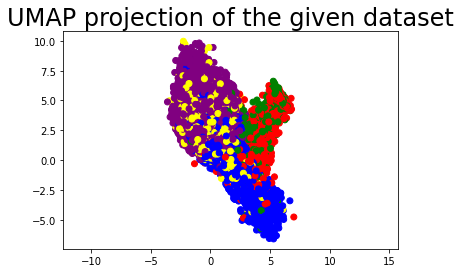

In [ ]:
colors = ['', 'red', 'green', 'blue', 'yellow', 'purple']

plt.scatter(
    umap_test['col1'],
    umap_test['col2'],
    c=[colors[x] for x in highest['churn_risk_score']]    
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the given dataset', fontsize=24)
plt.show()

In [ ]:
preds = rfc.predict(final_test_flat)
preds.shape

(19919,)

In [ ]:
Counter(preds)

Counter({0: 3027, 1: 5394, 2: 921, 3: 10577})

In [ ]:
final_preds = le.inverse_transform(preds).astype(int)
final_preds

array([4, 1, 4, ..., 1, 4, 2])

In [ ]:
sub = pd.DataFrame(
    {
        'customer_id': raw_test['customer_id'],
        'churn_risk_score': final_preds
    }
)
print(sub.info())
sub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19919 entries, 0 to 19918
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       19919 non-null  object
 1   churn_risk_score  19919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 311.4+ KB
None


,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,4
1,fffe43004900440031003900370037003300,1
2,fffe43004900440034003800360037003000,4
3,fffe43004900440036003200370033003400,4
4,fffe43004900440035003000370031003900,4


In [ ]:
sub.to_csv('umap_rfc.csv', index=False)

# playground

*   all ones => 2.77726
*   all twos => 2.83069
*   all_threes => 9.10945
*   all_fours => 8.86056
*   all_fives => 8.49878

In [ ]:
highest = pd.read_csv('/content/pycaret_lgb2.csv')
highest.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [ ]:
highest['churn_risk_score'].value_counts()

5    6849
3    5812
4    4242
1    1696
2    1320
Name: churn_risk_score, dtype: int64

In [ ]:
high_sub_df = pd.concat(
    [umap_test, highest['churn_risk_score']],
    axis=1,
)

high_sub_df

,col1,col2,churn_risk_score
0,1.390334,0.338645,3
1,0.609855,1.292722,3
2,1.041191,3.027527,3
3,0.924417,1.639800,3
4,1.437664,1.443471,5
...,...,...,...
19914,0.733776,0.605645,3
19915,-2.311420,5.227225,5
19916,-2.653395,3.195674,5
19917,1.218186,2.629214,4


In [ ]:
mask = (
    (high_sub_df['col2'] < 0) 
    # & (high_sub_df['col1'] < 2)
    & (high_sub_df['churn_risk_score'].isin([5]))
)
high_sub_df.loc[mask, 'churn_risk_score'] = 3

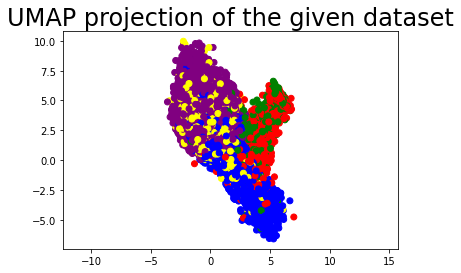

In [ ]:
colors = ['', 'red', 'green', 'blue', 'yellow', 'purple']
# mask = high_sub_df['churn_risk_score'] == 4
data = umap_test.copy()

plt.scatter(
    data['col1'],
    data['col2'],
    c=[colors[x] for x in high_sub_df['churn_risk_score']]    
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the given dataset', fontsize=24)
plt.show()

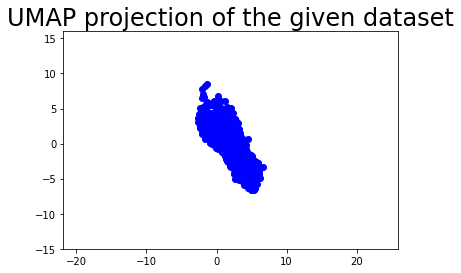

In [ ]:
target = 3
colors = ['', 'red', 'green', 'blue', 'yellow', 'purple']
mask = high_sub_df['churn_risk_score'] == target
data = umap_test.loc[mask]

plt.scatter(
    data['col1'],
    data['col2'],
    c=colors[target]   
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the given dataset', fontsize=24)
# plt.xlim([-5, 15])
plt.ylim([-15, 16])
plt.show()

In [ ]:
sub = pd.DataFrame(
    {
        'customer_id': raw_test['customer_id'],
        'churn_risk_score': high_sub_df['churn_risk_score']
    }
)
sub.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [ ]:
sub.to_csv('test6.csv', index=False)

# new try

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/HackerEarth Challenge/churn_risk_rate_pred/data/full_data.csv')

In [ ]:
print(df.info())
df.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56911 entries, 0 to 56910
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           56911 non-null  int64  
 1   gender                        56911 non-null  object 
 2   region_category               56911 non-null  object 
 3   membership_category           56911 non-null  object 
 4   joined_through_referral       56911 non-null  object 
 5   preferred_offer_types         56911 non-null  object 
 6   medium_of_operation           56911 non-null  object 
 7   internet_option               56911 non-null  object 
 8   days_since_last_login         56911 non-null  float64
 9   avg_time_spent                56911 non-null  float64
 10  avg_transaction_value         56911 non-null  float64
 11  avg_frequency_login_days      56911 non-null  float64
 12  points_in_wallet              56911 non-null  float64
 13  u

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,complaint_status,feedback,churn_risk_score,days_passed
28735,11,F,Town,Basic Membership,Yes,Without Offers,Smartphone,Mobile_Data,18.0,350.59,26907.38,14.0,599.63,No,Yes,Not Applicable,Negative,5.0,840


In [ ]:
# removing all -1 churn score
new_df = df.loc[df['churn_risk_score'] != -1].reset_index(drop=True)
new_df.shape

(55748, 19)

In [ ]:
cat_cols = new_df.select_dtypes(include='object').columns.tolist()
cont_cols = new_df.select_dtypes(exclude='object').columns.tolist()

cont_cols.remove('churn_risk_score')

print(cat_cols)
cont_cols

['gender', 'region_category', 'membership_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'used_special_discount', 'offer_application_preference', 'complaint_status', 'feedback']


['age',
 'days_since_last_login',
 'avg_time_spent',
 'avg_transaction_value',
 'avg_frequency_login_days',
 'points_in_wallet',
 'days_passed']

In [ ]:
for col in cat_cols:
    le = LabelEncoder()
    new_df[col] = le.fit_transform(new_df[col])

In [ ]:
mask = new_df['churn_risk_score'].isna()
test = new_df.loc[mask]
train = new_df.loc[~mask]

print(train.shape, test.shape)

(35829, 19) (19919, 19)


In [ ]:
for col in cont_cols:
    sc = RobustScaler()
    train[col] = sc.fit_transform(train[[col]])
    test[col] = sc.transform(test[[col]])

In [ ]:
test.drop('churn_risk_score', axis=1, inplace=True)

In [ ]:
train.sample()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,complaint_status,feedback,churn_risk_score,days_passed
9679,0.0,0,1,1,0,2,2,2,-0.428571,-0.398691,-0.406746,-0.916667,0.612668,0,1,1,0,3.0,-0.231047


In [ ]:
test.sample()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,complaint_status,feedback,days_passed
53859,-0.071429,0,0,0,1,2,3,0,0.571429,-0.318022,-0.499387,-0.416667,-1.087814,0,1,1,0,-0.151625


In [ ]:
X = train.drop('churn_risk_score', axis=1)
y = train['churn_risk_score'].astype(int)

In [ ]:
# nm = NearMiss()
# X_res, y_res = nm.fit_resample(X, y)

In [ ]:
# print(X_res.shape)
# np.unique(y_res, return_counts=True)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35829 entries, 0 to 35828
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           35829 non-null  float64
 1   gender                        35829 non-null  int64  
 2   region_category               35829 non-null  int64  
 3   membership_category           35829 non-null  int64  
 4   joined_through_referral       35829 non-null  int64  
 5   preferred_offer_types         35829 non-null  int64  
 6   medium_of_operation           35829 non-null  int64  
 7   internet_option               35829 non-null  int64  
 8   days_since_last_login         35829 non-null  float64
 9   avg_time_spent                35829 non-null  float64
 10  avg_transaction_value         35829 non-null  float64
 11  avg_frequency_login_days      35829 non-null  float64
 12  points_in_wallet              35829 non-null  float64
 13  u

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

## lightgbm

In [ ]:
##########################################################################
# require preprocessed X_train, X_test, y_train, y_test to run this cell #
##########################################################################

lgb_params = {
    # 'device_type': 'gpu',
    'objective': 'multiclass',
    'task': 'train',
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'n_estimators': 10000,
    'learning_rate': 0.33,
    'max_depth': 7,
    "num_leaves": 64,  
    "max_bin": 512,
    'subsample': 0.8,
    'min_child_samples': 32,
    'early_stopping_round': 200,
    'reg_alpha': 0.1,
    'reg_lambda': 0.5,
    # 'bagging_freq': 10,
    # 'categorical_feature': '',
    # 'colsample_bytree': 0.8,
    # 'colsample_bynode': 0.8,
    # 'random_strength': 2,
    # 'one_hot_max_size': 4,
    'verbosity': -5,
    'seed': 1234,
    'n_jobs': 2,
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='multi_logloss', verbose=False)
preds = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)
print(f"F1 Score = {f1_score(y_test, preds, average='macro'):.5f}")

F1 Score = 0.78043


In [ ]:
n_folds = 5
scores = []
kf = KFold(n_splits=n_folds, random_state=1234, shuffle=True)

for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

    train_x, valid_x = X.values[train_index], X.values[valid_index]
    train_y, valid_y = y[train_index], y[valid_index]

    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric='multi_logloss', verbose=False)
    preds = model.predict(valid_x)
    f1 = f1_score(valid_y, preds, average='macro')
    scores.append(f1)
    print(f"Fold {fold + 1}: {f1:.6f}")

print(f'Mean Score: {np.mean(scores)}')

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 0: 0.773367
Fold 1: 0.767065
Fold 2: 0.777565
Fold 3: 0.756852
Fold 4: 0.762922
Mean Score: 0.7675543848720366


In [ ]:
y.nunique()
test.shape[0]

19919

In [ ]:
n_folds = 5
scores = []
oof_preds = np.zeros((test.shape[0], y.nunique()))
kf = KFold(n_splits=n_folds, random_state=1234, shuffle=True)

for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

    train_x, valid_x = X.values[train_index], X.values[valid_index]
    train_y, valid_y = y[train_index], y[valid_index]

    model = lgb.LGBMClassifier(**lgb_params)

    model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric='multi_logloss', verbose=False)
    preds = model.predict(valid_x)
    
    oof_preds += model.predict_proba(test) / n_folds

    f1 = f1_score(valid_y, preds, average='macro')
    scores.append(f1)
    print(f"Fold {fold + 1}: {f1:.6f}")

final_preds = np.argmax(oof_preds, axis=1) + 1
print(f'Mean Score: {np.mean(scores)}')

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1: 0.770421
Fold 2: 0.770410
Fold 3: 0.771943
Fold 4: 0.761039
Fold 5: 0.760211
Mean Score: 0.7668047052152289


array([1, 2, 3, 4, 5])

In [ ]:
def objective(trial):
    # To select which parameters to optimize, please look at the LightGBM documentation:
    # https://lightgbm.readthedocs.io/en/latest/Parameters.html
    param = {
        # 'device_type': 'gpu',  # Use GPU acceleration
        'objective': 'multiclass',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int("n_estimators", 2000, 4000),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.2, 0.4),
        # 'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 0.05),
        # 'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 1),
        # 'colsample_bytree': trial.suggest_categorical('colsample_bytree', np.linspace(1, 1, num=1)),
        # 'colsample_bynode': trial.suggest_categorical('colsample_bynode', np.linspace(0.7, 1, num=4)),
        # 'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'verbosity': -1,
        'random_state': 1234,
        'n_jobs': -1,
    }
    model = lgb.LGBMClassifier(**param)      
    model.fit(
        X_train, y_train, eval_set=[(X_test, y_test)], \
        early_stopping_rounds=1000, eval_metric='multi_logloss', verbose=False
    )
    preds = model.predict(X_test, num_iteration=lgb_model.best_iteration_)
    f1 = f1_score(y_test, preds, average='macro')
    return f1

In [ ]:
lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(objective, n_trials=30)

[I 2021-04-14 19:13:33,253] A new study created in memory with name: no-name-da07665d-e644-451d-93f9-cda7565b9f4e


[1]	valid_0's multi_logloss: 0.740643
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.567046
[3]	valid_0's multi_logloss: 0.479433
[4]	valid_0's multi_logloss: 0.430416
[5]	valid_0's multi_logloss: 0.403614
[6]	valid_0's multi_logloss: 0.38739
[7]	valid_0's multi_logloss: 0.374093
[8]	valid_0's multi_logloss: 0.367297
[9]	valid_0's multi_logloss: 0.363666
[10]	valid_0's multi_logloss: 0.360139
[11]	valid_0's multi_logloss: 0.360029
[12]	valid_0's multi_logloss: 0.360009
[13]	valid_0's multi_logloss: 0.36088
[14]	valid_0's multi_logloss: 0.360393
[15]	valid_0's multi_logloss: 0.358962
[16]	valid_0's multi_logloss: 0.358314
[17]	valid_0's multi_logloss: 0.359262
[18]	valid_0's multi_logloss: 0.360023
[19]	valid_0's multi_logloss: 0.360436
[20]	valid_0's multi_logloss: 0.361184
[21]	valid_0's multi_logloss: 0.361665
[22]	valid_0's multi_logloss: 0.362697
[23]	valid_0's multi_logloss: 0.364113
[24]	valid_0's multi_logloss: 0.364927
[25]	valid_0

[I 2021-04-14 19:13:50,040] Trial 0 finished with value: 0.7685211229438036 and parameters: {'n_estimators': 3516, 'max_depth': 9, 'learning_rate': 0.36279221251030197}. Best is trial 0 with value: 0.7685211229438036.


[1010]	valid_0's multi_logloss: 0.990674
[1011]	valid_0's multi_logloss: 0.991236
[1012]	valid_0's multi_logloss: 0.991689
[1013]	valid_0's multi_logloss: 0.992289
[1014]	valid_0's multi_logloss: 0.99292
[1015]	valid_0's multi_logloss: 0.993801
[1016]	valid_0's multi_logloss: 0.994149
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 0.358314
[1]	valid_0's multi_logloss: 0.7504
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.574574
[3]	valid_0's multi_logloss: 0.485164
[4]	valid_0's multi_logloss: 0.434388
[5]	valid_0's multi_logloss: 0.406358
[6]	valid_0's multi_logloss: 0.389284
[7]	valid_0's multi_logloss: 0.37499
[8]	valid_0's multi_logloss: 0.368684
[9]	valid_0's multi_logloss: 0.364509
[10]	valid_0's multi_logloss: 0.361995
[11]	valid_0's multi_logloss: 0.360433
[12]	valid_0's multi_logloss: 0.359243
[13]	valid_0's multi_logloss: 0.357763
[14]	valid_0's multi_logloss: 0.358139
[15]	valid_0's multi_logloss: 0.359101
[16]

[I 2021-04-14 19:14:07,289] Trial 1 finished with value: 0.7695747195631621 and parameters: {'n_estimators': 3924, 'max_depth': 9, 'learning_rate': 0.3542256980200958}. Best is trial 1 with value: 0.7695747195631621.


[1005]	valid_0's multi_logloss: 0.988592
[1006]	valid_0's multi_logloss: 0.989116
[1007]	valid_0's multi_logloss: 0.989597
[1008]	valid_0's multi_logloss: 0.99021
[1009]	valid_0's multi_logloss: 0.990301
[1010]	valid_0's multi_logloss: 0.991145
[1011]	valid_0's multi_logloss: 0.991806
[1012]	valid_0's multi_logloss: 0.992559
[1013]	valid_0's multi_logloss: 0.992894
Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 0.357763
[1]	valid_0's multi_logloss: 0.862118
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.669105
[3]	valid_0's multi_logloss: 0.558768
[4]	valid_0's multi_logloss: 0.490146
[5]	valid_0's multi_logloss: 0.445078
[6]	valid_0's multi_logloss: 0.416656
[7]	valid_0's multi_logloss: 0.396007
[8]	valid_0's multi_logloss: 0.382864
[9]	valid_0's multi_logloss: 0.371022
[10]	valid_0's multi_logloss: 0.36465
[11]	valid_0's multi_logloss: 0.359996
[12]	valid_0's multi_logloss: 0.356263
[13]	valid_0's multi_logloss: 0.35364

[I 2021-04-14 19:14:23,974] Trial 2 finished with value: 0.7735514323920175 and parameters: {'n_estimators': 2744, 'max_depth': 7, 'learning_rate': 0.2710784505631007}. Best is trial 2 with value: 0.7735514323920175.


[1010]	valid_0's multi_logloss: 0.873932
[1011]	valid_0's multi_logloss: 0.874353
[1012]	valid_0's multi_logloss: 0.874894
[1013]	valid_0's multi_logloss: 0.8751
[1014]	valid_0's multi_logloss: 0.875655
[1015]	valid_0's multi_logloss: 0.876418
[1016]	valid_0's multi_logloss: 0.876783
[1017]	valid_0's multi_logloss: 0.877657
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.348896
[1]	valid_0's multi_logloss: 0.940017
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.733634
[3]	valid_0's multi_logloss: 0.616763
[4]	valid_0's multi_logloss: 0.543605
[5]	valid_0's multi_logloss: 0.489676
[6]	valid_0's multi_logloss: 0.452579
[7]	valid_0's multi_logloss: 0.424681
[8]	valid_0's multi_logloss: 0.405586
[9]	valid_0's multi_logloss: 0.391993
[10]	valid_0's multi_logloss: 0.380038
[11]	valid_0's multi_logloss: 0.373625
[12]	valid_0's multi_logloss: 0.366083
[13]	valid_0's multi_logloss: 0.361413
[14]	valid_0's multi_logloss: 0.358948


[I 2021-04-14 19:14:37,973] Trial 3 finished with value: 0.7826661907163798 and parameters: {'n_estimators': 2969, 'max_depth': 4, 'learning_rate': 0.2702749306408321}. Best is trial 3 with value: 0.7826661907163798.


[1033]	valid_0's multi_logloss: 0.639707
[1034]	valid_0's multi_logloss: 0.639811
[1035]	valid_0's multi_logloss: 0.640039
[1036]	valid_0's multi_logloss: 0.640317
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.337198
[1]	valid_0's multi_logloss: 0.829112
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.641506
[3]	valid_0's multi_logloss: 0.535818
[4]	valid_0's multi_logloss: 0.472193
[5]	valid_0's multi_logloss: 0.431353
[6]	valid_0's multi_logloss: 0.407256
[7]	valid_0's multi_logloss: 0.388912
[8]	valid_0's multi_logloss: 0.377259
[9]	valid_0's multi_logloss: 0.36902
[10]	valid_0's multi_logloss: 0.363231
[11]	valid_0's multi_logloss: 0.359277
[12]	valid_0's multi_logloss: 0.356353
[13]	valid_0's multi_logloss: 0.355188
[14]	valid_0's multi_logloss: 0.354421
[15]	valid_0's multi_logloss: 0.352798
[16]	valid_0's multi_logloss: 0.35263
[17]	valid_0's multi_logloss: 0.353635
[18]	valid_0's multi_logloss: 0.353421
[19]	val

[I 2021-04-14 19:14:54,719] Trial 4 finished with value: 0.7714281917821617 and parameters: {'n_estimators': 3920, 'max_depth': 8, 'learning_rate': 0.2931124738005466}. Best is trial 3 with value: 0.7826661907163798.


[1]	valid_0's multi_logloss: 0.928641
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.734621
[3]	valid_0's multi_logloss: 0.615345
[4]	valid_0's multi_logloss: 0.538144
[5]	valid_0's multi_logloss: 0.485192
[6]	valid_0's multi_logloss: 0.447692
[7]	valid_0's multi_logloss: 0.4209
[8]	valid_0's multi_logloss: 0.402921
[9]	valid_0's multi_logloss: 0.387788
[10]	valid_0's multi_logloss: 0.375513
[11]	valid_0's multi_logloss: 0.367553
[12]	valid_0's multi_logloss: 0.36162
[13]	valid_0's multi_logloss: 0.35704
[14]	valid_0's multi_logloss: 0.353827
[15]	valid_0's multi_logloss: 0.35126
[16]	valid_0's multi_logloss: 0.348973
[17]	valid_0's multi_logloss: 0.34754
[18]	valid_0's multi_logloss: 0.346706
[19]	valid_0's multi_logloss: 0.345305
[20]	valid_0's multi_logloss: 0.344136
[21]	valid_0's multi_logloss: 0.343327
[22]	valid_0's multi_logloss: 0.342852
[23]	valid_0's multi_logloss: 0.342994
[24]	valid_0's multi_logloss: 0.343144
[25]	valid_0's m

[I 2021-04-14 19:15:12,078] Trial 5 finished with value: 0.7745727359199506 and parameters: {'n_estimators': 3492, 'max_depth': 6, 'learning_rate': 0.23273767037014062}. Best is trial 3 with value: 0.7826661907163798.


[1024]	valid_0's multi_logloss: 0.800865
[1025]	valid_0's multi_logloss: 0.801107
[1026]	valid_0's multi_logloss: 0.801254
[1027]	valid_0's multi_logloss: 0.801671
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.342751
[1]	valid_0's multi_logloss: 0.919275
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.723337
[3]	valid_0's multi_logloss: 0.604555
[4]	valid_0's multi_logloss: 0.528865
[5]	valid_0's multi_logloss: 0.477026
[6]	valid_0's multi_logloss: 0.441706
[7]	valid_0's multi_logloss: 0.418353
[8]	valid_0's multi_logloss: 0.401633
[9]	valid_0's multi_logloss: 0.388085
[10]	valid_0's multi_logloss: 0.376579
[11]	valid_0's multi_logloss: 0.370101
[12]	valid_0's multi_logloss: 0.364643
[13]	valid_0's multi_logloss: 0.361982
[14]	valid_0's multi_logloss: 0.358874
[15]	valid_0's multi_logloss: 0.356501
[16]	valid_0's multi_logloss: 0.355922
[17]	valid_0's multi_logloss: 0.354483
[18]	valid_0's multi_logloss: 0.353343
[19]	v

[I 2021-04-14 19:15:29,420] Trial 6 finished with value: 0.7721265488979218 and parameters: {'n_estimators': 3323, 'max_depth': 10, 'learning_rate': 0.2359909182226139}. Best is trial 3 with value: 0.7826661907163798.


[1]	valid_0's multi_logloss: 0.752815
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.576999
[3]	valid_0's multi_logloss: 0.486547
[4]	valid_0's multi_logloss: 0.432586
[5]	valid_0's multi_logloss: 0.401818
[6]	valid_0's multi_logloss: 0.38316
[7]	valid_0's multi_logloss: 0.369829
[8]	valid_0's multi_logloss: 0.361275
[9]	valid_0's multi_logloss: 0.355599
[10]	valid_0's multi_logloss: 0.352831
[11]	valid_0's multi_logloss: 0.349779
[12]	valid_0's multi_logloss: 0.348164
[13]	valid_0's multi_logloss: 0.347451
[14]	valid_0's multi_logloss: 0.347265
[15]	valid_0's multi_logloss: 0.347458
[16]	valid_0's multi_logloss: 0.347228
[17]	valid_0's multi_logloss: 0.347065
[18]	valid_0's multi_logloss: 0.346629
[19]	valid_0's multi_logloss: 0.347241
[20]	valid_0's multi_logloss: 0.347678
[21]	valid_0's multi_logloss: 0.347428
[22]	valid_0's multi_logloss: 0.3482
[23]	valid_0's multi_logloss: 0.348703
[24]	valid_0's multi_logloss: 0.349548
[25]	valid_0'

[I 2021-04-14 19:15:46,562] Trial 7 finished with value: 0.7757894642172859 and parameters: {'n_estimators': 2790, 'max_depth': 6, 'learning_rate': 0.35432086939343704}. Best is trial 3 with value: 0.7826661907163798.


[1010]	valid_0's multi_logloss: 1.02413
[1011]	valid_0's multi_logloss: 1.02448
[1012]	valid_0's multi_logloss: 1.02467
[1013]	valid_0's multi_logloss: 1.02514
[1014]	valid_0's multi_logloss: 1.0255
[1015]	valid_0's multi_logloss: 1.0259
[1016]	valid_0's multi_logloss: 1.02599
[1017]	valid_0's multi_logloss: 1.02618
[1018]	valid_0's multi_logloss: 1.02736
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.346629
[1]	valid_0's multi_logloss: 0.86895
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.676006
[3]	valid_0's multi_logloss: 0.564013
[4]	valid_0's multi_logloss: 0.494491
[5]	valid_0's multi_logloss: 0.44994
[6]	valid_0's multi_logloss: 0.421381
[7]	valid_0's multi_logloss: 0.402335
[8]	valid_0's multi_logloss: 0.387973
[9]	valid_0's multi_logloss: 0.37516
[10]	valid_0's multi_logloss: 0.369571
[11]	valid_0's multi_logloss: 0.36425
[12]	valid_0's multi_logloss: 0.360834
[13]	valid_0's multi_logloss: 0.357584
[14]	valid_

[I 2021-04-14 19:16:03,676] Trial 8 finished with value: 0.7695441583677931 and parameters: {'n_estimators': 3908, 'max_depth': 10, 'learning_rate': 0.2665203408565954}. Best is trial 3 with value: 0.7826661907163798.


[1016]	valid_0's multi_logloss: 0.847966
[1017]	valid_0's multi_logloss: 0.848411
[1018]	valid_0's multi_logloss: 0.848756
[1019]	valid_0's multi_logloss: 0.849052
[1020]	valid_0's multi_logloss: 0.849822
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.351696
[1]	valid_0's multi_logloss: 0.910485
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.714852
[3]	valid_0's multi_logloss: 0.596824
[4]	valid_0's multi_logloss: 0.522082
[5]	valid_0's multi_logloss: 0.471358
[6]	valid_0's multi_logloss: 0.437195
[7]	valid_0's multi_logloss: 0.414999
[8]	valid_0's multi_logloss: 0.398723
[9]	valid_0's multi_logloss: 0.384909
[10]	valid_0's multi_logloss: 0.375538
[11]	valid_0's multi_logloss: 0.367776
[12]	valid_0's multi_logloss: 0.363644
[13]	valid_0's multi_logloss: 0.359953
[14]	valid_0's multi_logloss: 0.357101
[15]	valid_0's multi_logloss: 0.355106
[16]	valid_0's multi_logloss: 0.353647
[17]	valid_0's multi_logloss: 0.352003
[18]

[I 2021-04-14 19:16:21,693] Trial 9 finished with value: 0.7682795001422086 and parameters: {'n_estimators': 3044, 'max_depth': 9, 'learning_rate': 0.24127711989674647}. Best is trial 3 with value: 0.7826661907163798.


[1026]	valid_0's multi_logloss: 0.78832
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.350384
[1]	valid_0's multi_logloss: 0.87991
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.668704
[3]	valid_0's multi_logloss: 0.563289
[4]	valid_0's multi_logloss: 0.495399
[5]	valid_0's multi_logloss: 0.449996
[6]	valid_0's multi_logloss: 0.421478
[7]	valid_0's multi_logloss: 0.399433
[8]	valid_0's multi_logloss: 0.383996
[9]	valid_0's multi_logloss: 0.373431
[10]	valid_0's multi_logloss: 0.365572
[11]	valid_0's multi_logloss: 0.360458
[12]	valid_0's multi_logloss: 0.356995
[13]	valid_0's multi_logloss: 0.352096
[14]	valid_0's multi_logloss: 0.349214
[15]	valid_0's multi_logloss: 0.347536
[16]	valid_0's multi_logloss: 0.346362
[17]	valid_0's multi_logloss: 0.346009
[18]	valid_0's multi_logloss: 0.344923
[19]	valid_0's multi_logloss: 0.34212
[20]	valid_0's multi_logloss: 0.341477
[21]	valid_0's multi_logloss: 0.340085
[22]	valid_0's 

[I 2021-04-14 19:16:35,956] Trial 10 finished with value: 0.7791250086288264 and parameters: {'n_estimators': 2171, 'max_depth': 4, 'learning_rate': 0.3168777395271728}. Best is trial 3 with value: 0.7826661907163798.


[1030]	valid_0's multi_logloss: 0.694348
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.338576
[1]	valid_0's multi_logloss: 0.879072
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.667883
[3]	valid_0's multi_logloss: 0.562604
[4]	valid_0's multi_logloss: 0.494836
[5]	valid_0's multi_logloss: 0.449527
[6]	valid_0's multi_logloss: 0.421094
[7]	valid_0's multi_logloss: 0.399118
[8]	valid_0's multi_logloss: 0.38373
[9]	valid_0's multi_logloss: 0.373207
[10]	valid_0's multi_logloss: 0.365385
[11]	valid_0's multi_logloss: 0.360297
[12]	valid_0's multi_logloss: 0.356847
[13]	valid_0's multi_logloss: 0.351969
[14]	valid_0's multi_logloss: 0.349103
[15]	valid_0's multi_logloss: 0.347436
[16]	valid_0's multi_logloss: 0.346271
[17]	valid_0's multi_logloss: 0.345925
[18]	valid_0's multi_logloss: 0.344847
[19]	valid_0's multi_logloss: 0.342055
[20]	valid_0's multi_logloss: 0.341481
[21]	valid_0's multi_logloss: 0.340317
[22]	valid_0'

[I 2021-04-14 19:16:50,369] Trial 11 finished with value: 0.7800326807643637 and parameters: {'n_estimators': 2020, 'max_depth': 4, 'learning_rate': 0.31757988419219807}. Best is trial 3 with value: 0.7826661907163798.


[1023]	valid_0's multi_logloss: 0.708762
[1024]	valid_0's multi_logloss: 0.709247
[1025]	valid_0's multi_logloss: 0.709901
[1026]	valid_0's multi_logloss: 0.709978
[1027]	valid_0's multi_logloss: 0.710387
[1028]	valid_0's multi_logloss: 0.710924
[1029]	valid_0's multi_logloss: 0.711311
[1030]	valid_0's multi_logloss: 0.711632
[1031]	valid_0's multi_logloss: 0.711704
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.338121
[1]	valid_0's multi_logloss: 0.878792
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.66761
[3]	valid_0's multi_logloss: 0.562375
[4]	valid_0's multi_logloss: 0.494648
[5]	valid_0's multi_logloss: 0.449371
[6]	valid_0's multi_logloss: 0.420966
[7]	valid_0's multi_logloss: 0.399013
[8]	valid_0's multi_logloss: 0.383642
[9]	valid_0's multi_logloss: 0.373132
[10]	valid_0's multi_logloss: 0.365321
[11]	valid_0's multi_logloss: 0.360241
[12]	valid_0's multi_logloss: 0.356798
[13]	valid_0's multi_logloss: 0.3519

[I 2021-04-14 19:17:04,797] Trial 12 finished with value: 0.7746507820639376 and parameters: {'n_estimators': 2109, 'max_depth': 4, 'learning_rate': 0.31781479698369536}. Best is trial 3 with value: 0.7826661907163798.


[1]	valid_0's multi_logloss: 1.00493
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.810821
[3]	valid_0's multi_logloss: 0.686656
[4]	valid_0's multi_logloss: 0.603131
[5]	valid_0's multi_logloss: 0.542629
[6]	valid_0's multi_logloss: 0.496735
[7]	valid_0's multi_logloss: 0.462242
[8]	valid_0's multi_logloss: 0.435856
[9]	valid_0's multi_logloss: 0.415278
[10]	valid_0's multi_logloss: 0.398552
[11]	valid_0's multi_logloss: 0.387129
[12]	valid_0's multi_logloss: 0.377854
[13]	valid_0's multi_logloss: 0.370659
[14]	valid_0's multi_logloss: 0.364888
[15]	valid_0's multi_logloss: 0.360535
[16]	valid_0's multi_logloss: 0.35706
[17]	valid_0's multi_logloss: 0.353979
[18]	valid_0's multi_logloss: 0.351625
[19]	valid_0's multi_logloss: 0.34992
[20]	valid_0's multi_logloss: 0.34793
[21]	valid_0's multi_logloss: 0.346871
[22]	valid_0's multi_logloss: 0.34533
[23]	valid_0's multi_logloss: 0.344249
[24]	valid_0's multi_logloss: 0.343309
[25]	valid_0's 

[I 2021-04-14 19:17:22,076] Trial 13 finished with value: 0.7757408229565547 and parameters: {'n_estimators': 2402, 'max_depth': 5, 'learning_rate': 0.20122916101533966}. Best is trial 3 with value: 0.7826661907163798.


[1029]	valid_0's multi_logloss: 0.698762
[1030]	valid_0's multi_logloss: 0.699108
[1031]	valid_0's multi_logloss: 0.699317
[1032]	valid_0's multi_logloss: 0.699775
[1033]	valid_0's multi_logloss: 0.70014
[1034]	valid_0's multi_logloss: 0.700397
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.339877
[1]	valid_0's multi_logloss: 0.871119
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.660129
[3]	valid_0's multi_logloss: 0.552664
[4]	valid_0's multi_logloss: 0.486993
[5]	valid_0's multi_logloss: 0.444839
[6]	valid_0's multi_logloss: 0.417646
[7]	valid_0's multi_logloss: 0.397133
[8]	valid_0's multi_logloss: 0.382629
[9]	valid_0's multi_logloss: 0.370687
[10]	valid_0's multi_logloss: 0.363816
[11]	valid_0's multi_logloss: 0.35735
[12]	valid_0's multi_logloss: 0.353798
[13]	valid_0's multi_logloss: 0.351166
[14]	valid_0's multi_logloss: 0.348578
[15]	valid_0's multi_logloss: 0.3472
[16]	valid_0's multi_logloss: 0.344759
[17]	v

[I 2021-04-14 19:17:36,563] Trial 14 finished with value: 0.7793038492071249 and parameters: {'n_estimators': 2444, 'max_depth': 4, 'learning_rate': 0.3243230267387815}. Best is trial 3 with value: 0.7826661907163798.


[1023]	valid_0's multi_logloss: 0.714214
[1024]	valid_0's multi_logloss: 0.714412
[1025]	valid_0's multi_logloss: 0.714883
[1026]	valid_0's multi_logloss: 0.715225
[1027]	valid_0's multi_logloss: 0.715468
[1028]	valid_0's multi_logloss: 0.715795
[1029]	valid_0's multi_logloss: 0.716443
[1030]	valid_0's multi_logloss: 0.716467
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.33796
[1]	valid_0's multi_logloss: 0.866342
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.670918
[3]	valid_0's multi_logloss: 0.561657
[4]	valid_0's multi_logloss: 0.493001
[5]	valid_0's multi_logloss: 0.447451
[6]	valid_0's multi_logloss: 0.415724
[7]	valid_0's multi_logloss: 0.394583
[8]	valid_0's multi_logloss: 0.378335
[9]	valid_0's multi_logloss: 0.36845
[10]	valid_0's multi_logloss: 0.360867
[11]	valid_0's multi_logloss: 0.356669
[12]	valid_0's multi_logloss: 0.352844
[13]	valid_0's multi_logloss: 0.350124
[14]	valid_0's multi_logloss: 0.34781
[

[I 2021-04-14 19:17:53,846] Trial 15 finished with value: 0.7759963291729274 and parameters: {'n_estimators': 2004, 'max_depth': 5, 'learning_rate': 0.28598422567639187}. Best is trial 3 with value: 0.7826661907163798.


[1014]	valid_0's multi_logloss: 0.844175
[1015]	valid_0's multi_logloss: 0.844353
[1016]	valid_0's multi_logloss: 0.844699
[1017]	valid_0's multi_logloss: 0.845038
[1018]	valid_0's multi_logloss: 0.845545
[1019]	valid_0's multi_logloss: 0.845802
[1020]	valid_0's multi_logloss: 0.846544
[1021]	valid_0's multi_logloss: 0.847065
[1022]	valid_0's multi_logloss: 0.847689
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.340485
[1]	valid_0's multi_logloss: 0.737225
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.561697
[3]	valid_0's multi_logloss: 0.472889
[4]	valid_0's multi_logloss: 0.422137
[5]	valid_0's multi_logloss: 0.392258
[6]	valid_0's multi_logloss: 0.371597
[7]	valid_0's multi_logloss: 0.361472
[8]	valid_0's multi_logloss: 0.355176
[9]	valid_0's multi_logloss: 0.351119
[10]	valid_0's multi_logloss: 0.347945
[11]	valid_0's multi_logloss: 0.345729
[12]	valid_0's multi_logloss: 0.345159
[13]	valid_0's multi_logloss: 0.344

[I 2021-04-14 19:18:10,888] Trial 16 finished with value: 0.7762546119889658 and parameters: {'n_estimators': 3061, 'max_depth': 5, 'learning_rate': 0.39301821545153565}. Best is trial 3 with value: 0.7826661907163798.


[1007]	valid_0's multi_logloss: 1.04108
[1008]	valid_0's multi_logloss: 1.04157
[1009]	valid_0's multi_logloss: 1.04212
[1010]	valid_0's multi_logloss: 1.04235
[1011]	valid_0's multi_logloss: 1.04374
[1012]	valid_0's multi_logloss: 1.04374
[1013]	valid_0's multi_logloss: 1.04393
[1014]	valid_0's multi_logloss: 1.04441
[1015]	valid_0's multi_logloss: 1.04564
[1016]	valid_0's multi_logloss: 1.04624
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 0.343398
[1]	valid_0's multi_logloss: 0.986252
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.792199
[3]	valid_0's multi_logloss: 0.668236
[4]	valid_0's multi_logloss: 0.584754
[5]	valid_0's multi_logloss: 0.525019
[6]	valid_0's multi_logloss: 0.481546
[7]	valid_0's multi_logloss: 0.449499
[8]	valid_0's multi_logloss: 0.426081
[9]	valid_0's multi_logloss: 0.408175
[10]	valid_0's multi_logloss: 0.393477
[11]	valid_0's multi_logloss: 0.382484
[12]	valid_0's multi_logloss: 0.373833
[13]

[I 2021-04-14 19:18:28,939] Trial 17 finished with value: 0.771398751721325 and parameters: {'n_estimators': 2551, 'max_depth': 6, 'learning_rate': 0.2011922935634301}. Best is trial 3 with value: 0.7826661907163798.


[1028]	valid_0's multi_logloss: 0.724854
[1029]	valid_0's multi_logloss: 0.725102
[1030]	valid_0's multi_logloss: 0.725434
[1031]	valid_0's multi_logloss: 0.725738
[1032]	valid_0's multi_logloss: 0.726212
[1033]	valid_0's multi_logloss: 0.726473
[1034]	valid_0's multi_logloss: 0.726905
[1035]	valid_0's multi_logloss: 0.727099
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.341224
[1]	valid_0's multi_logloss: 0.858602
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.647949
[3]	valid_0's multi_logloss: 0.542559
[4]	valid_0's multi_logloss: 0.478773
[5]	valid_0's multi_logloss: 0.437404
[6]	valid_0's multi_logloss: 0.411434
[7]	valid_0's multi_logloss: 0.392445
[8]	valid_0's multi_logloss: 0.378395
[9]	valid_0's multi_logloss: 0.368933
[10]	valid_0's multi_logloss: 0.362128
[11]	valid_0's multi_logloss: 0.357381
[12]	valid_0's multi_logloss: 0.353916
[13]	valid_0's multi_logloss: 0.351145
[14]	valid_0's multi_logloss: 0.34805

[I 2021-04-14 19:18:43,750] Trial 18 finished with value: 0.7795994675965137 and parameters: {'n_estimators': 3291, 'max_depth': 4, 'learning_rate': 0.33525081566205484}. Best is trial 3 with value: 0.7826661907163798.


[1021]	valid_0's multi_logloss: 0.711389
[1022]	valid_0's multi_logloss: 0.711702
[1023]	valid_0's multi_logloss: 0.712229
[1024]	valid_0's multi_logloss: 0.712366
[1025]	valid_0's multi_logloss: 0.712791
[1026]	valid_0's multi_logloss: 0.713268
[1027]	valid_0's multi_logloss: 0.713728
[1028]	valid_0's multi_logloss: 0.71418
[1029]	valid_0's multi_logloss: 0.714529
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.338362
[1]	valid_0's multi_logloss: 0.896836
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.700115
[3]	valid_0's multi_logloss: 0.585357
[4]	valid_0's multi_logloss: 0.514315
[5]	valid_0's multi_logloss: 0.465183
[6]	valid_0's multi_logloss: 0.429953
[7]	valid_0's multi_logloss: 0.405734
[8]	valid_0's multi_logloss: 0.387319
[9]	valid_0's multi_logloss: 0.375453
[10]	valid_0's multi_logloss: 0.367407
[11]	valid_0's multi_logloss: 0.361182
[12]	valid_0's multi_logloss: 0.356272
[13]	valid_0's multi_logloss: 0.3521

[I 2021-04-14 19:19:01,252] Trial 19 finished with value: 0.77680568923608 and parameters: {'n_estimators': 2223, 'max_depth': 5, 'learning_rate': 0.2653901462459816}. Best is trial 3 with value: 0.7826661907163798.



[1031]	valid_0's multi_logloss: 0.810094
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.34032
[1]	valid_0's multi_logloss: 0.819772
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.632079
[3]	valid_0's multi_logloss: 0.528671
[4]	valid_0's multi_logloss: 0.465371
[5]	valid_0's multi_logloss: 0.425966
[6]	valid_0's multi_logloss: 0.400687
[7]	valid_0's multi_logloss: 0.38475
[8]	valid_0's multi_logloss: 0.372997
[9]	valid_0's multi_logloss: 0.366356
[10]	valid_0's multi_logloss: 0.360233
[11]	valid_0's multi_logloss: 0.355995
[12]	valid_0's multi_logloss: 0.353476
[13]	valid_0's multi_logloss: 0.351861
[14]	valid_0's multi_logloss: 0.350325
[15]	valid_0's multi_logloss: 0.34919
[16]	valid_0's multi_logloss: 0.34937
[17]	valid_0's multi_logloss: 0.348758
[18]	valid_0's multi_logloss: 0.349054
[19]	valid_0's multi_logloss: 0.348604
[20]	valid_0's multi_logloss: 0.349192
[21]	valid_0's multi_logloss: 0.348935
[22]	valid_0's 

[I 2021-04-14 19:19:19,085] Trial 20 finished with value: 0.7752083913747654 and parameters: {'n_estimators': 3686, 'max_depth': 7, 'learning_rate': 0.2997185032197457}. Best is trial 3 with value: 0.7826661907163798.


[1020]	valid_0's multi_logloss: 0.912938
[1021]	valid_0's multi_logloss: 0.913429
[1022]	valid_0's multi_logloss: 0.913682
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.348405
[1]	valid_0's multi_logloss: 0.85958
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.64889
[3]	valid_0's multi_logloss: 0.543339
[4]	valid_0's multi_logloss: 0.479404
[5]	valid_0's multi_logloss: 0.437921
[6]	valid_0's multi_logloss: 0.411906
[7]	valid_0's multi_logloss: 0.392887
[8]	valid_0's multi_logloss: 0.378699
[9]	valid_0's multi_logloss: 0.368617
[10]	valid_0's multi_logloss: 0.362902
[11]	valid_0's multi_logloss: 0.357692
[12]	valid_0's multi_logloss: 0.353904
[13]	valid_0's multi_logloss: 0.350267
[14]	valid_0's multi_logloss: 0.348377
[15]	valid_0's multi_logloss: 0.346834
[16]	valid_0's multi_logloss: 0.345473
[17]	valid_0's multi_logloss: 0.343321
[18]	valid_0's multi_logloss: 0.342336
[19]	valid_0's multi_logloss: 0.342313
[20]	valid

[I 2021-04-14 19:19:34,124] Trial 21 finished with value: 0.7780631949002295 and parameters: {'n_estimators': 3190, 'max_depth': 4, 'learning_rate': 0.33438277942855815}. Best is trial 3 with value: 0.7826661907163798.


[1023]	valid_0's multi_logloss: 0.73721
[1024]	valid_0's multi_logloss: 0.737686
[1025]	valid_0's multi_logloss: 0.737948
[1026]	valid_0's multi_logloss: 0.738071
[1027]	valid_0's multi_logloss: 0.738429
[1028]	valid_0's multi_logloss: 0.738902
[1029]	valid_0's multi_logloss: 0.739599
[1030]	valid_0's multi_logloss: 0.740459
[1031]	valid_0's multi_logloss: 0.740693
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.338201
[1]	valid_0's multi_logloss: 0.805219
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.597357
[3]	valid_0's multi_logloss: 0.500829
[4]	valid_0's multi_logloss: 0.444853
[5]	valid_0's multi_logloss: 0.411512
[6]	valid_0's multi_logloss: 0.391112
[7]	valid_0's multi_logloss: 0.376004
[8]	valid_0's multi_logloss: 0.366872
[9]	valid_0's multi_logloss: 0.358443
[10]	valid_0's multi_logloss: 0.35347
[11]	valid_0's multi_logloss: 0.349401
[12]	valid_0's multi_logloss: 0.347876
[13]	valid_0's multi_logloss: 0.34538

[I 2021-04-14 19:19:48,996] Trial 22 finished with value: 0.7769526964704736 and parameters: {'n_estimators': 2837, 'max_depth': 4, 'learning_rate': 0.3870208454007297}. Best is trial 3 with value: 0.7826661907163798.


[1]	valid_0's multi_logloss: 0.80243
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.61531
[3]	valid_0's multi_logloss: 0.515797
[4]	valid_0's multi_logloss: 0.455471
[5]	valid_0's multi_logloss: 0.417204
[6]	valid_0's multi_logloss: 0.391768
[7]	valid_0's multi_logloss: 0.37565
[8]	valid_0's multi_logloss: 0.364136
[9]	valid_0's multi_logloss: 0.358392
[10]	valid_0's multi_logloss: 0.353979
[11]	valid_0's multi_logloss: 0.349655
[12]	valid_0's multi_logloss: 0.347447
[13]	valid_0's multi_logloss: 0.34602
[14]	valid_0's multi_logloss: 0.343403
[15]	valid_0's multi_logloss: 0.342659
[16]	valid_0's multi_logloss: 0.34208
[17]	valid_0's multi_logloss: 0.341853
[18]	valid_0's multi_logloss: 0.341414
[19]	valid_0's multi_logloss: 0.340641
[20]	valid_0's multi_logloss: 0.34127
[21]	valid_0's multi_logloss: 0.341366
[22]	valid_0's multi_logloss: 0.341685
[23]	valid_0's multi_logloss: 0.341932
[24]	valid_0's multi_logloss: 0.341819
[25]	valid_0's m

[I 2021-04-14 19:20:06,463] Trial 23 finished with value: 0.7758259017683837 and parameters: {'n_estimators': 3314, 'max_depth': 5, 'learning_rate': 0.33420600009554113}. Best is trial 3 with value: 0.7826661907163798.


[1016]	valid_0's multi_logloss: 0.931983
[1017]	valid_0's multi_logloss: 0.932335
[1018]	valid_0's multi_logloss: 0.932568
[1019]	valid_0's multi_logloss: 0.933198
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.340641
[1]	valid_0's multi_logloss: 0.818446
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.609993
[3]	valid_0's multi_logloss: 0.5117
[4]	valid_0's multi_logloss: 0.453761
[5]	valid_0's multi_logloss: 0.418357
[6]	valid_0's multi_logloss: 0.394489
[7]	valid_0's multi_logloss: 0.378357
[8]	valid_0's multi_logloss: 0.368273
[9]	valid_0's multi_logloss: 0.36075
[10]	valid_0's multi_logloss: 0.356543
[11]	valid_0's multi_logloss: 0.351288
[12]	valid_0's multi_logloss: 0.349181
[13]	valid_0's multi_logloss: 0.348205
[14]	valid_0's multi_logloss: 0.345315
[15]	valid_0's multi_logloss: 0.34401
[16]	valid_0's multi_logloss: 0.342959
[17]	valid_0's multi_logloss: 0.342426
[18]	valid_0's multi_logloss: 0.342211
[19]	valid

[I 2021-04-14 19:20:21,500] Trial 24 finished with value: 0.7783713378836316 and parameters: {'n_estimators': 3699, 'max_depth': 4, 'learning_rate': 0.3733100320019652}. Best is trial 3 with value: 0.7826661907163798.


[1]	valid_0's multi_logloss: 0.812755
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.628979
[3]	valid_0's multi_logloss: 0.524256
[4]	valid_0's multi_logloss: 0.463304
[5]	valid_0's multi_logloss: 0.424699
[6]	valid_0's multi_logloss: 0.399158
[7]	valid_0's multi_logloss: 0.381105
[8]	valid_0's multi_logloss: 0.369501
[9]	valid_0's multi_logloss: 0.361993
[10]	valid_0's multi_logloss: 0.35795
[11]	valid_0's multi_logloss: 0.353472
[12]	valid_0's multi_logloss: 0.351482
[13]	valid_0's multi_logloss: 0.34883
[14]	valid_0's multi_logloss: 0.347572
[15]	valid_0's multi_logloss: 0.346564
[16]	valid_0's multi_logloss: 0.345103
[17]	valid_0's multi_logloss: 0.345098
[18]	valid_0's multi_logloss: 0.34475
[19]	valid_0's multi_logloss: 0.345015
[20]	valid_0's multi_logloss: 0.345139
[21]	valid_0's multi_logloss: 0.345127
[22]	valid_0's multi_logloss: 0.345342
[23]	valid_0's multi_logloss: 0.345863
[24]	valid_0's multi_logloss: 0.345842
[25]	valid_0'

[I 2021-04-14 19:20:39,470] Trial 25 finished with value: 0.770378130600328 and parameters: {'n_estimators': 2954, 'max_depth': 6, 'learning_rate': 0.307177751814621}. Best is trial 3 with value: 0.7826661907163798.


[1011]	valid_0's multi_logloss: 0.940654
[1012]	valid_0's multi_logloss: 0.940929
[1013]	valid_0's multi_logloss: 0.941694
[1014]	valid_0's multi_logloss: 0.943036
[1015]	valid_0's multi_logloss: 0.943328
[1016]	valid_0's multi_logloss: 0.943924
[1017]	valid_0's multi_logloss: 0.944525
[1018]	valid_0's multi_logloss: 0.944942
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.34475
[1]	valid_0's multi_logloss: 0.796487
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.610104
[3]	valid_0's multi_logloss: 0.511669
[4]	valid_0's multi_logloss: 0.452549
[5]	valid_0's multi_logloss: 0.414931
[6]	valid_0's multi_logloss: 0.389582
[7]	valid_0's multi_logloss: 0.373449
[8]	valid_0's multi_logloss: 0.362736
[9]	valid_0's multi_logloss: 0.357297
[10]	valid_0's multi_logloss: 0.353345
[11]	valid_0's multi_logloss: 0.349208
[12]	valid_0's multi_logloss: 0.347037
[13]	valid_0's multi_logloss: 0.345152
[14]	valid_0's multi_logloss: 0.342705

[I 2021-04-14 19:20:57,265] Trial 26 finished with value: 0.7833077709266502 and parameters: {'n_estimators': 3290, 'max_depth': 5, 'learning_rate': 0.33910901666671833}. Best is trial 26 with value: 0.7833077709266502.


[1024]	valid_0's multi_logloss: 0.945496
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.340754
[1]	valid_0's multi_logloss: 0.870845
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.675168
[3]	valid_0's multi_logloss: 0.565201
[4]	valid_0's multi_logloss: 0.495921
[5]	valid_0's multi_logloss: 0.450019
[6]	valid_0's multi_logloss: 0.417916
[7]	valid_0's multi_logloss: 0.394577
[8]	valid_0's multi_logloss: 0.379147
[9]	valid_0's multi_logloss: 0.367596
[10]	valid_0's multi_logloss: 0.360666
[11]	valid_0's multi_logloss: 0.355928
[12]	valid_0's multi_logloss: 0.35094
[13]	valid_0's multi_logloss: 0.348659
[14]	valid_0's multi_logloss: 0.346638
[15]	valid_0's multi_logloss: 0.3454
[16]	valid_0's multi_logloss: 0.34341
[17]	valid_0's multi_logloss: 0.342457
[18]	valid_0's multi_logloss: 0.341567
[19]	valid_0's multi_logloss: 0.340562
[20]	valid_0's multi_logloss: 0.34002
[21]	valid_0's multi_logloss: 0.339995
[22]	valid_0's mu

[I 2021-04-14 19:21:14,989] Trial 27 finished with value: 0.775532755747885 and parameters: {'n_estimators': 2615, 'max_depth': 5, 'learning_rate': 0.2828570601826208}. Best is trial 26 with value: 0.7833077709266502.


[1024]	valid_0's multi_logloss: 0.841976
[1025]	valid_0's multi_logloss: 0.842773
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.339158
[1]	valid_0's multi_logloss: 0.92205
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.724813
[3]	valid_0's multi_logloss: 0.607976
[4]	valid_0's multi_logloss: 0.532802
[5]	valid_0's multi_logloss: 0.480755
[6]	valid_0's multi_logloss: 0.442719
[7]	valid_0's multi_logloss: 0.416174
[8]	valid_0's multi_logloss: 0.395673
[9]	valid_0's multi_logloss: 0.382077
[10]	valid_0's multi_logloss: 0.371124
[11]	valid_0's multi_logloss: 0.364052
[12]	valid_0's multi_logloss: 0.359158
[13]	valid_0's multi_logloss: 0.354886
[14]	valid_0's multi_logloss: 0.352415
[15]	valid_0's multi_logloss: 0.350183
[16]	valid_0's multi_logloss: 0.347649
[17]	valid_0's multi_logloss: 0.34584
[18]	valid_0's multi_logloss: 0.344683
[19]	valid_0's multi_logloss: 0.34363
[20]	valid_0's multi_logloss: 0.342503
[21]	valid_0'

[I 2021-04-14 19:21:32,979] Trial 28 finished with value: 0.7781213412125877 and parameters: {'n_estimators': 3501, 'max_depth': 5, 'learning_rate': 0.24930843442669695}. Best is trial 26 with value: 0.7833077709266502.


[1024]	valid_0's multi_logloss: 0.787276
[1025]	valid_0's multi_logloss: 0.787692
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.339448
[1]	valid_0's multi_logloss: 0.738786
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 0.565213
[3]	valid_0's multi_logloss: 0.477716
[4]	valid_0's multi_logloss: 0.426947
[5]	valid_0's multi_logloss: 0.396974
[6]	valid_0's multi_logloss: 0.379582
[7]	valid_0's multi_logloss: 0.367184
[8]	valid_0's multi_logloss: 0.359699
[9]	valid_0's multi_logloss: 0.355284
[10]	valid_0's multi_logloss: 0.351608
[11]	valid_0's multi_logloss: 0.350549
[12]	valid_0's multi_logloss: 0.348459
[13]	valid_0's multi_logloss: 0.347774
[14]	valid_0's multi_logloss: 0.347974
[15]	valid_0's multi_logloss: 0.348173
[16]	valid_0's multi_logloss: 0.347626
[17]	valid_0's multi_logloss: 0.347588
[18]	valid_0's multi_logloss: 0.348166
[19]	valid_0's multi_logloss: 0.348836
[20]	valid_0's multi_logloss: 0.349328
[21]	valid

[I 2021-04-14 19:21:51,156] Trial 29 finished with value: 0.7709165145462598 and parameters: {'n_estimators': 3762, 'max_depth': 6, 'learning_rate': 0.36654797966674985}. Best is trial 26 with value: 0.7833077709266502.


[1017]	valid_0's multi_logloss: 1.0484
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.347588


In [ ]:
# BEST_PARAMS = {
#     'objective': 'multiclass',
#     'boosting_type': 'gbdt',
#     # 'device_type': 'gpu',
#     'metric': 'multi_logloss',
#     'n_jobs': -1,
#     'verbosity': -1,
#     'random_state': 1234,
# }

BEST_PARAMS = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.33910901666671833,
    'max_depth': 5,
    'metric': 'multi_logloss',
    'n_estimators': 3290,
    'n_jobs': -1,
    'objective': 'multiclass',
    'random_state': 1234,
    'verbosity': -1,
    # 'device_type': 'gpu',
}
# BEST_PARAMS.update(**lgb_study.best_params)
BEST_PARAMS   

{'boosting_type': 'gbdt',
 'learning_rate': 0.33910901666671833,
 'max_depth': 5,
 'metric': 'multi_logloss',
 'n_estimators': 3290,
 'n_jobs': -1,
 'objective': 'multiclass',
 'random_state': 1234,
 'verbosity': -1}

In [ ]:
# scores = cross_val_score(lgb_model, X, y, cv=5, scoring='f1_macro')
# print(scores)
# scores.mean()
n_folds = 5
scores = []
kf = KFold(n_splits=n_folds, random_state=1234, shuffle=True)

for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

    train_x, valid_x = X.values[train_index], X.values[valid_index]
    train_y, valid_y = y[train_index], y[valid_index]

    model = lgb.LGBMClassifier(**BEST_PARAMS)
    model.fit(train_x, train_y)
    preds = model.predict(valid_x)
    f1 = f1_score(valid_y, preds, average='macro')
    scores.append(f1)
    print(f"Fold {fold}: {f1:.6f}")

print(f'Mean Score: {np.mean(scores)}')

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 0: 0.7637929484831897
Fold 1: 0.7621335334725817
Fold 2: 0.7598137730414484
Fold 3: 0.7599692916476877
Fold 4: 0.744725353760943
Mean Score: 0.7580869800811701


In [ ]:
lgb_model.fit(X, y)
preds = lgb_model.predict(test)
print(preds.shape)
preds

(19919,)


array([3, 3, 4, ..., 5, 4, 3])

In [ ]:
#####################################
# fill the columns of the dataframe #
#####################################

sub = pd.DataFrame(
    {
        'customer_id': raw_test['customer_id'],
        'churn_risk_score': final_preds
    }
)
print(sub.shape)
sub.head()

(19919, 2)


,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,4
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [ ]:
SUB_FILEPATH = 'lgb_6.csv'
sub.to_csv(SUB_FILEPATH, index=False)

In [ ]:
sub.to_csv('lgb1.csv', index=False)

## xgboost

In [ ]:
xgb_params = {
    'tree_method': 'gpu_hist',
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'booster': 'gbtree',
    'n_estimators': 1000,
    'max_depth': 6,
    'learning_rate': 0.2,
    # 'gamma': 10,
    # 'min_child_weight': 0.4,
    # 'subsample': 0.9,
    # 'colsample_bytree': 0.1,
    # 'colsample_bylevel': 0.4,
    # 'colsample_bynode': 0.6,
    # 'reg_alpha': 10,
    # 'reg_lambda': 10,
    # 'scale_pos_weight': 4,
    # 'random_state': 1234,
    # 'importance_type': 'gain',
    # 'max_delta_step': ,
    # 'base_score': ,
    # 'tree_method': 'auto',
    # 'missing': ,
    # 'num_parallel_tree': ,
    # 'monotone_constraints': ,
    # 'interaction_constraints': ,
    'verbosity': 2,
    'n_jobs': -1,
}

In [ ]:
xgb_model = xgb.XGBClassifier(**xgb_params)

In [ ]:
# xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [ ]:
preds = xgb_model.predict(X_test)
f1_score(y_test, preds, average='macro')

0.7691125472000078

In [ ]:
scores = cross_val_score(xgb_model, X, y, cv=10, scoring='f1_macro')

In [ ]:
print(scores)
scores.mean()

[0.76512993 0.79473954 0.78541853 0.78764064 0.78938981 0.77509234
 0.78698758 0.75292143 0.78050797 0.7765333 ]


0.7794361056973613

In [ ]:
xgb_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=2)

In [ ]:
preds = xgb_model.predict(test)

In [ ]:
sub = pd.DataFrame(
    {
        'customer_id': raw_test['customer_id'],
        'churn_risk_score': preds
    }
)
print(sub.shape)
sub.sample()

(19919, 2)


,customer_id,churn_risk_score
17426,fffe43004900440035003800370030003800,3


In [ ]:
sub.to_csv('xgb_3.csv', index=False)